<a href="https://colab.research.google.com/github/NickPavlovskii/sber/blob/main/sber_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <center> <font color='green'> Virtual internship Data Science in Sberbank</center> 
 
<img src = "https://avatars.mds.yandex.net/i?id=fe571f0aae6550a77d761e1c53476f39-5190933-images-thumbs&n=13" width = 900 height = 300/>


В файле data_1.csv представлены подневные данные объема расчетных счетов физических лиц. В отличие от депозита, клиент может снять всю сумму с расчетного счета в любой момент времени без каких-либо «штрафов». Такой продукт называют Undefined Maturity Product – UMP). Однако маловероятно, что все клиенты разом закроют свои счета в Банке. Всегда кто-то снимает деньги, а кто-то пополняет счет – есть некоторый стабильный уровень, ниже которого не опустится суммарный обьем расчетных счетов.

Например, если бы мы знали будущее объема расчетных счетов, как на рисунке 1, то стабильная часть на 1 месяц (1м) была бы на уровне, обозначенным красным цветом. Это тот уровень, который не пробивается на протяжении 1 месяца. Аналогично 2м – зеленый, 3м – синий, 4м – розовый.

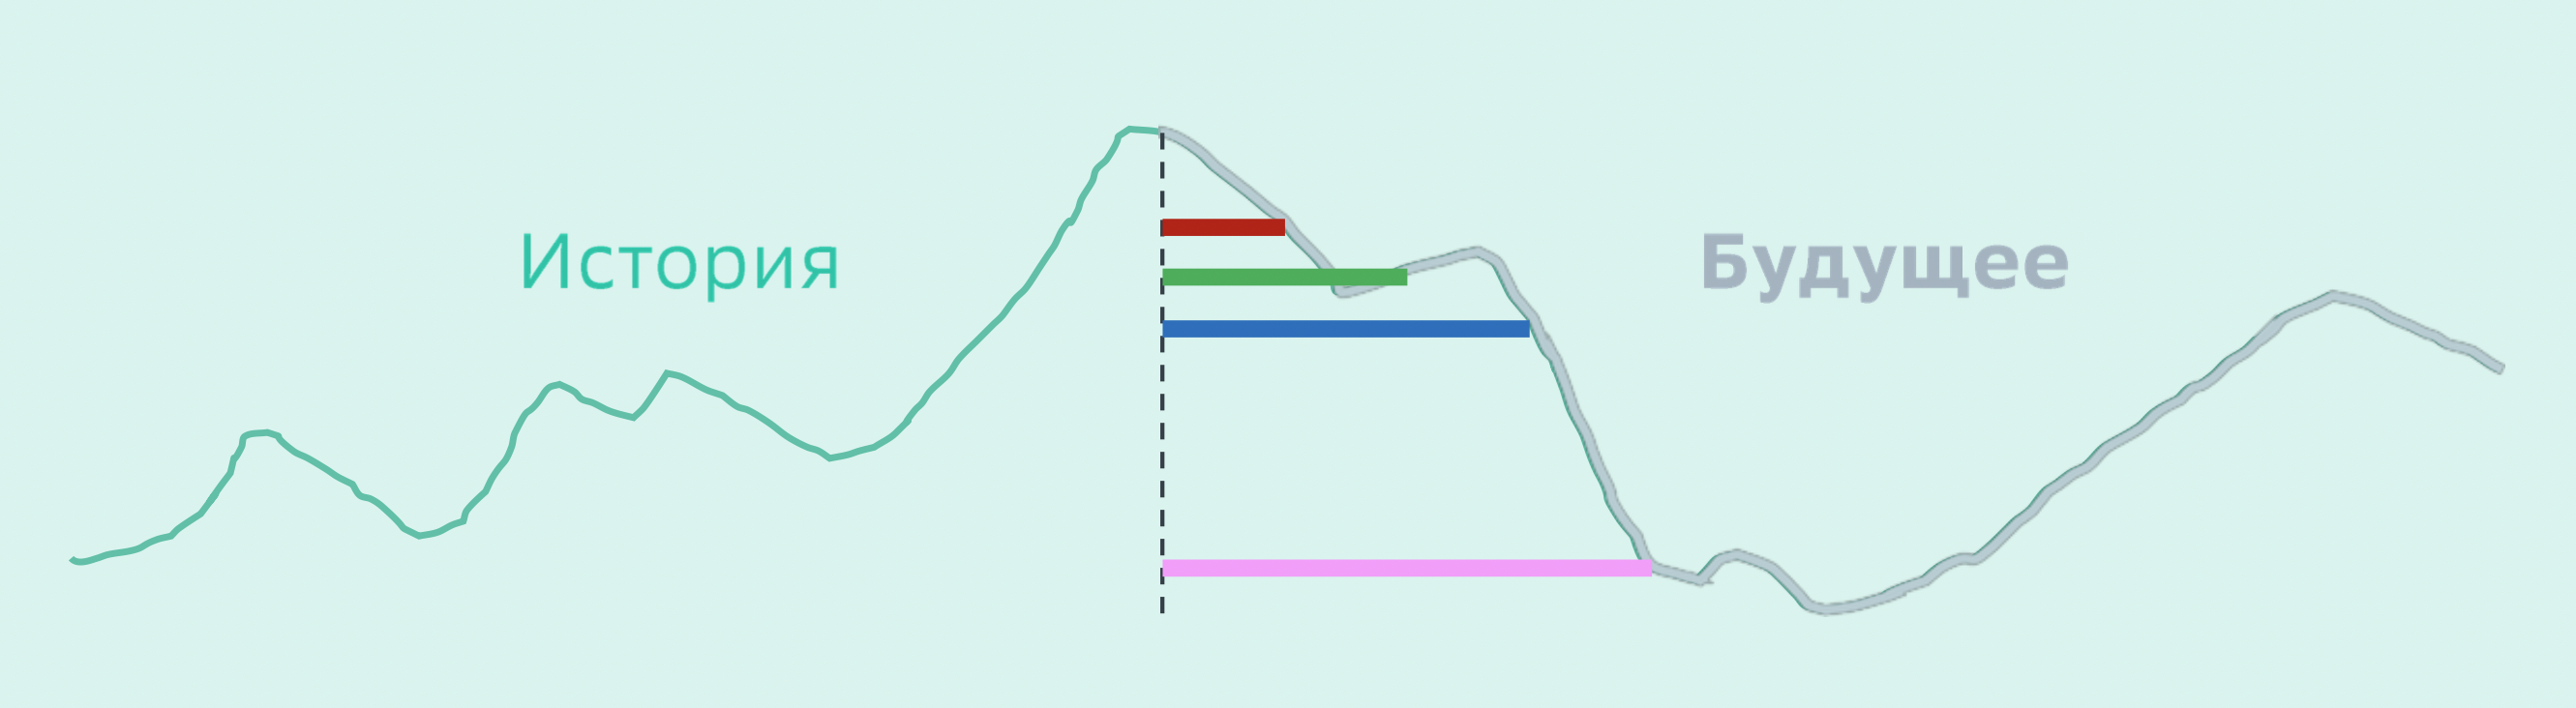

Задача: необходимо построить модель, которая оценивает обьем стабильной части средств на дату.


-  сделать прогноз объема расчетных счетов физических лиц на 1М, 2М, 3М...или др, 
- далее расчитывать минимальное значение объема `value` за данный промежуток. 

То есть после того, как сделал прогноз на промежуток 1 месяц, необходимо определить значение, ниже которого не опускается объема расчетных счетов физических лиц. 




 Оглавление :\
[1. Подготовка данных](#step_0) \
[2. Минимумв месяц(базовое решение)](#step_1) \
[3.Пробуе XGBOOST м ](#step_2 )\
[4.SARIMA)cезонность и тренд) ](#step_3 )\
[5.Arima ](#Arima )\
[6. SARIMA](#step_5) \
[7. LSTM](#step_6) \
[8. Skforecast](#step_7) \
[9. Обогатим данные](#step_8) \
[10.SARIMAX ](#step_9)\
[11. Лин регрессия](#step_10) \
[12.cезонность, тренд и остатки](#step_11) \
[13. Вывод](#step_12) \






---






<a id="title-one"></a>
<h1 style='background:#3CB371; border:2; border-radius: 10px; color:black'>
<center>Importing Libraries and Loading Data</center></h1>

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import statsmodels.api as sm
import numpy as np
from mpl_toolkits.mplot3d import Axes3D

# для исследования сезонности, тренда в данных
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import r2_score
from sklearn import metrics

from pylab import rcParams

# для теста на стационарность
from statsmodels.tsa.stattools import adfuller
from statsmodels.iolib.table import SimpleTable
from statsmodels.stats.stattools import jarque_bera 

import warnings
import itertools


from sklearn.linear_model import SGDRegressor
from sklearn.utils import resample
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score


import xgboost as xgb
import statsmodels.api as sm

# для форматирования графиков
%matplotlib inline
plt.rcParams.update({'font.size': 15, 
                     'figure.figsize': (18, 8), 
                     'axes.grid' : True})

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

<a id='step_0'></a>
# Подготовка данных

In [3]:
columns=['Date', 'value']

dataset = pd.read_csv('data_1.csv',
                   index_col=['Date'], 
                   parse_dates=['Date'], 
                   dayfirst=True, 
                   header=None, 
                   names=columns, 
                   infer_datetime_format="%d/%m/%y")

# dataset.dropna(subset=['value'], how='all')

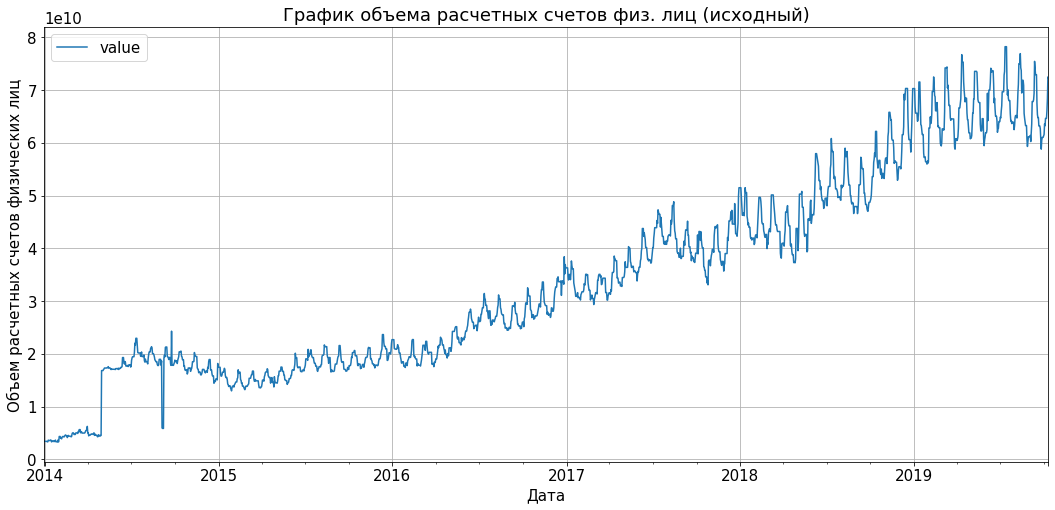

In [4]:
ax = dataset.plot(y='value', title='График объема расчетных счетов физ. лиц (исходный)')
ax.set_xlabel("Дата")
ax.set_ylabel("Объем расчетных счетов физических лиц");

Проанализировав этот график, можно сделать несколько выводов:

Баланс счета увеличивается к середине месяца, затем падает в течение 10-15 дней и снова начинает расти.
В некоторых точках графика наблюдается небольшое проседание ниже уровня предыдущего пика.
Общая тенденция направлена на увеличение, то есть временной ряд не является стационарным, поскольку его математическое ожидание растет со временем.

Попробуем избавиться от выброса во второй половине 2014 года

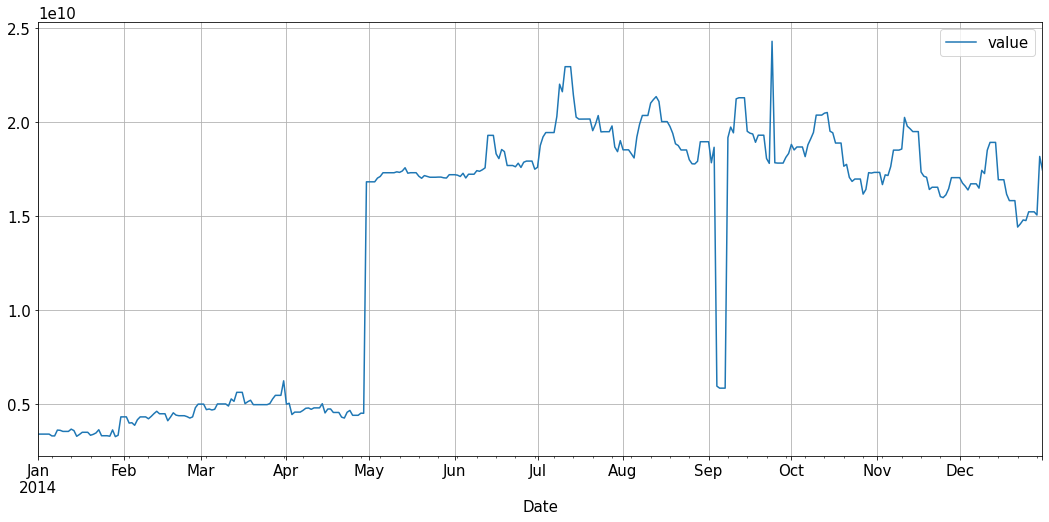

In [5]:
dataset.loc['2014'].plot(y='value');

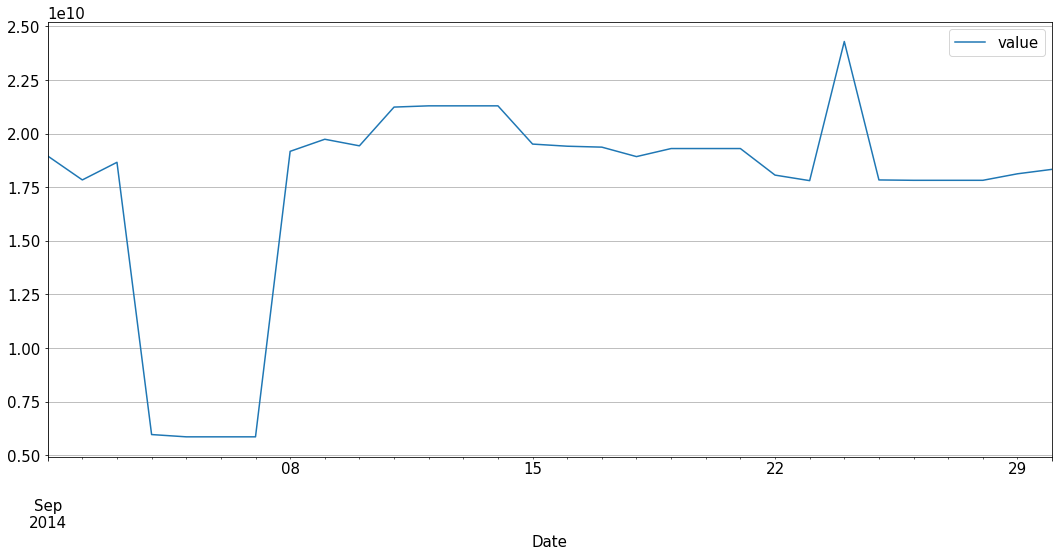

In [6]:
dataset.loc['2014-09'].plot(y='value');

C 04 сентября по 07 сентября 2014 года наблюдается резкий спад объема счетов физ. лиц. Предполагаемой причиной такого резкого спада могло стать подорожание евра,а так же понижения процентов на вкладах. В предполагаемой модели данный фактор не будет учтен, поэтому пока можно удалить данный выброс.

In [7]:
dataset = dataset.drop(['2014-09-04','2014-09-05','2014-09-06','2014-09-07'])


# dataset=dataset.drop(['2014-09-02','2014-09-03','2014-09-04','2014-09-05','2014-09-06','2014-09-07','2014-09-23','2014-09-24','2014-09-25'])


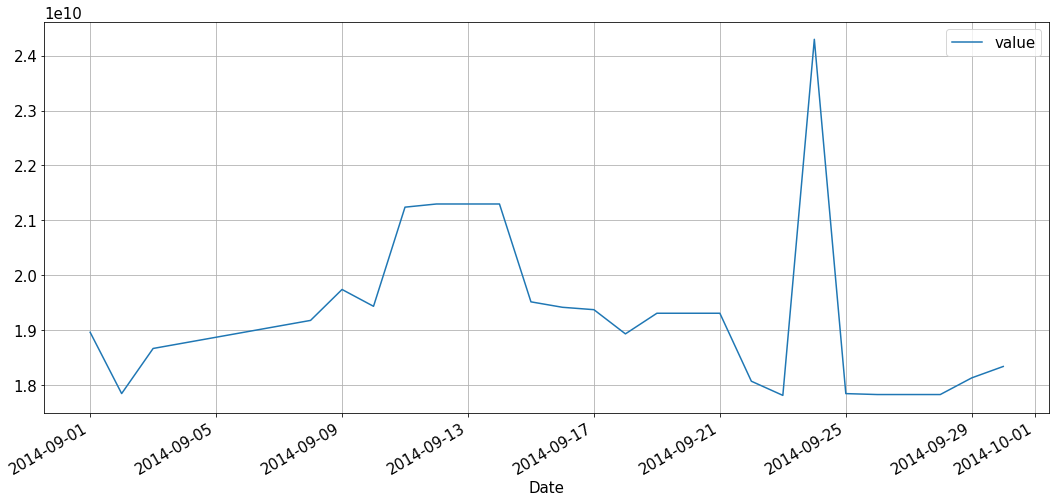

In [8]:
dataset.loc['2014-09'].plot(y='value');

In [9]:
dataset.info() 

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2107 entries, 2013-12-30 to 2019-10-10
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   value   2107 non-null   int64
dtypes: int64(1)
memory usage: 32.9 KB


Пропущенных значений нет

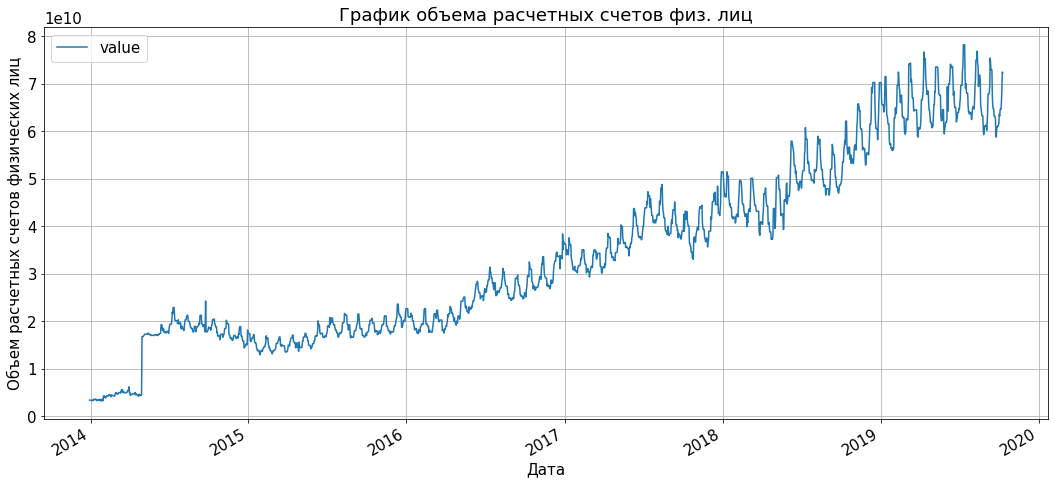

In [10]:
ax = dataset.plot(y='value', title='График объема расчетных счетов физ. лиц')
ax.set_xlabel("Дата")
ax.set_ylabel("Объем расчетных счетов физических лиц");

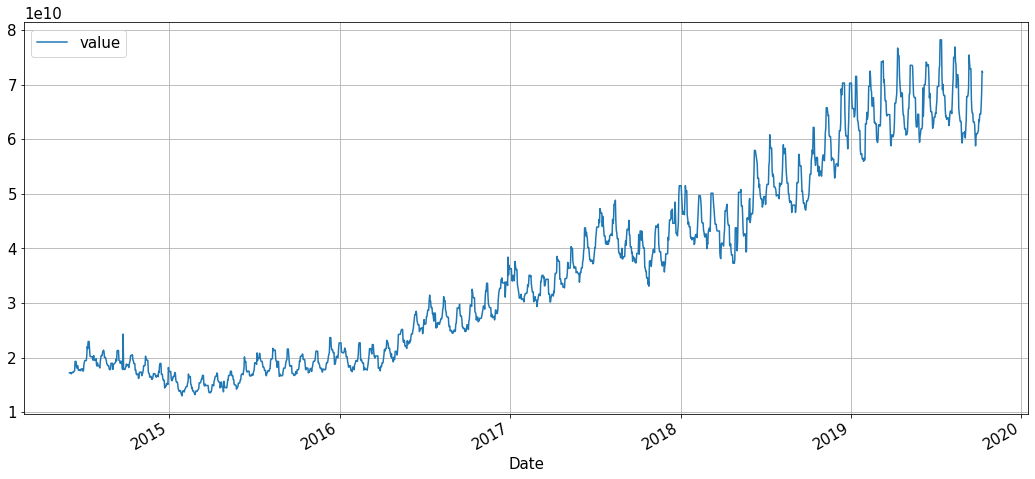

In [11]:
dataset=dataset['2014-06':]
dataset.plot(y='value')

Когда мы создаем прогнозирующую для временных рядов, нам требуются стационарные временные ряды, то есть обладающие одинаковой ковариацией, поэтому проведем проверку нашего ряда на стационарность с помощью теста Дики-Фуллера.

- H0 гипотеза: ряд не стационарен 
- H1 гипотеза: ряд стационарен


In [12]:
# Определяем функцию для теста ADF
def adf_test(timeseries):
    # Выполняем тест Дики-Фуллера:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

# применяем к ряду тест adf 
adf_test(dataset)

Results of Dickey-Fuller Test:
Test Statistic                    0.905860
p-value                           0.993166
Lags Used                        26.000000
Number of Observations Used    1927.000000
Critical Value (1%)              -3.433748
Critical Value (5%)              -2.863041
Critical Value (10%)             -2.567569
dtype: float64


$p_{value} = 0.991880, p_{value} > 0.05$ => p-значение для временного ряда больше 5%, следовательно не удалось опровергунть H0-гипотезу, то есть временной ряд не стационарен.

Видим,что график имеет выбросы. Так анализировать закрытие/открытие счетов за каждые день не имеет смысла, поэтому перейдем к неидеальному интервалу и среднему значению счетов на нем, тем самым уменьшим колебания нашего временного ряда

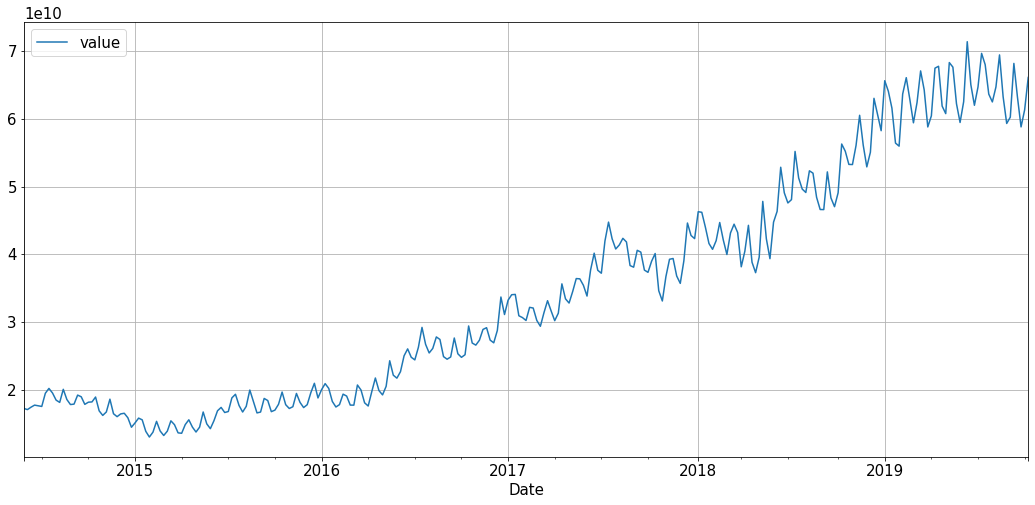

In [13]:
dataset1 = dataset.resample('W').agg('min')

dataset1.plot(y='value')

In [14]:
dt = pd.read_csv('data_1.csv',
                   index_col=['Date'], 
                   parse_dates=['Date'], 
                   dayfirst=True, 
                   header=None, 
                   names=columns, 
                   infer_datetime_format="%d/%m/%y")

# dt.dropna(subset=['value'], how='all')

In [15]:
dataset1 = dataset1.interpolate()

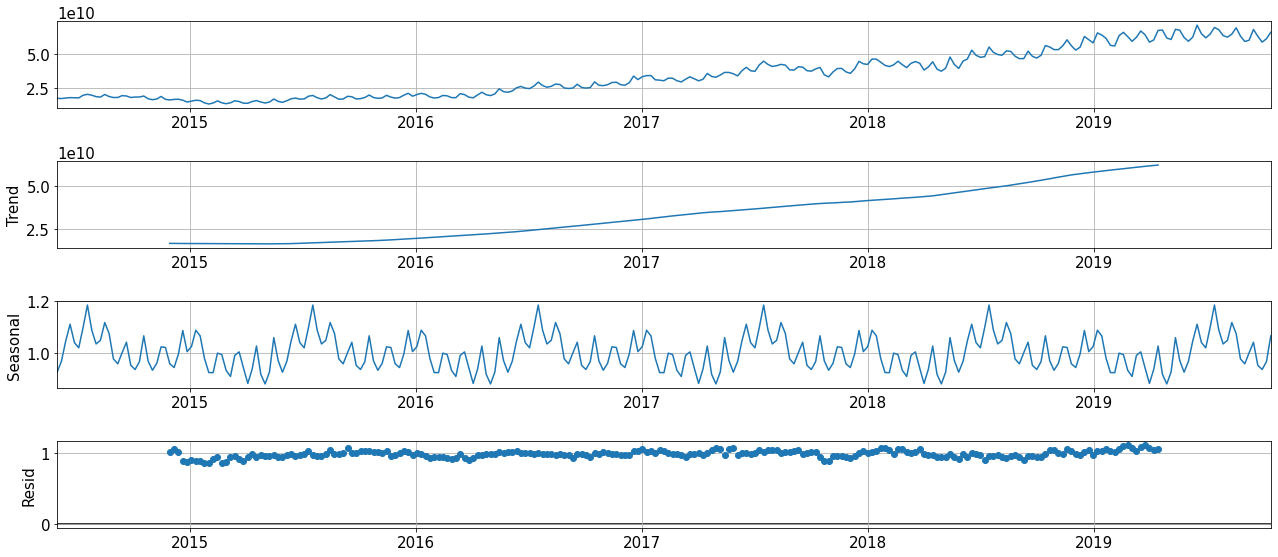

In [16]:
ts_dicomposition = seasonal_decompose(dataset1, model='multiplicate')
ts_dicomposition.plot();

Временные ряды [стационарный](https://en.wikipedia.org/wiki/Stationary_process) если они не имеют тенденции или сезонных эффектов. Наблюдения в стационарном временном ряду не зависят от времени. 

В нашем же случае можно выделить тренд и сезонность, значит ряд нестационарен

,value
count,2.810000e+02
mean,3.448205e+10
std,1.699632e+10
min,1.297964e+10
25%,1.837395e+10
50%,3.128010e+10
75%,4.658714e+10
max,7.139879e+10


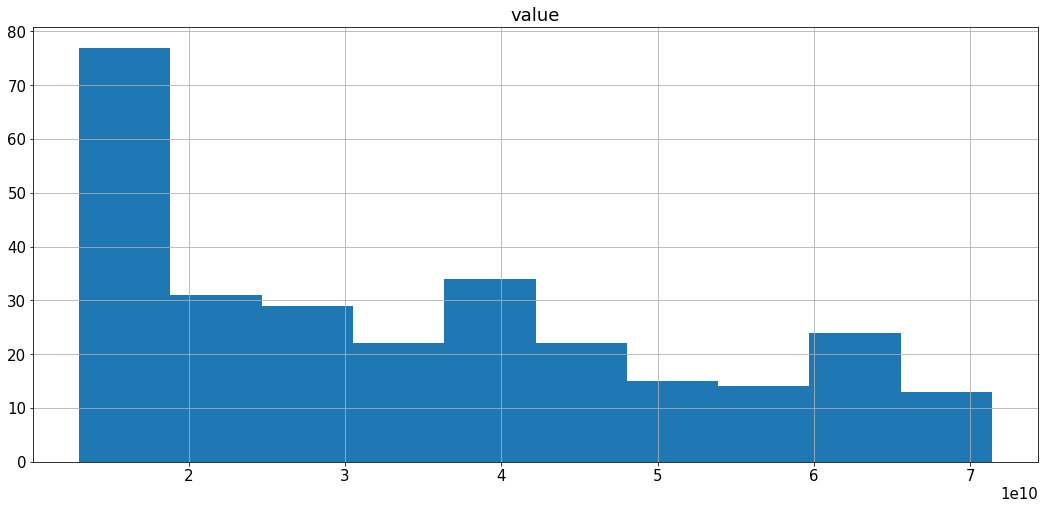

In [17]:
itog = dataset1.describe()
dataset1.hist()
itog

Можно предположить, что это логнормальное [распределение](https://ru.wikipedia.org/wiki/%D0%9B%D0%BE%D0%B3%D0%BD%D0%BE%D1%80%D0%BC%D0%B0%D0%BB%D1%8C%D0%BD%D0%BE%D0%B5_%D1%80%D0%B0%D1%81%D0%BF%D1%80%D0%B5%D0%B4%D0%B5%D0%BB%D0%B5%D0%BD%D0%B8%D0%B5)

Функция логарифма часто используется для моделей в экономике (например, модель спроса в ценообразование может быть описана логарифмом). Поэтому прологарифмируем наше значение, чтобы посмотреть на распределение логарифма величины.  

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f045396f090>]],
      dtype=object)

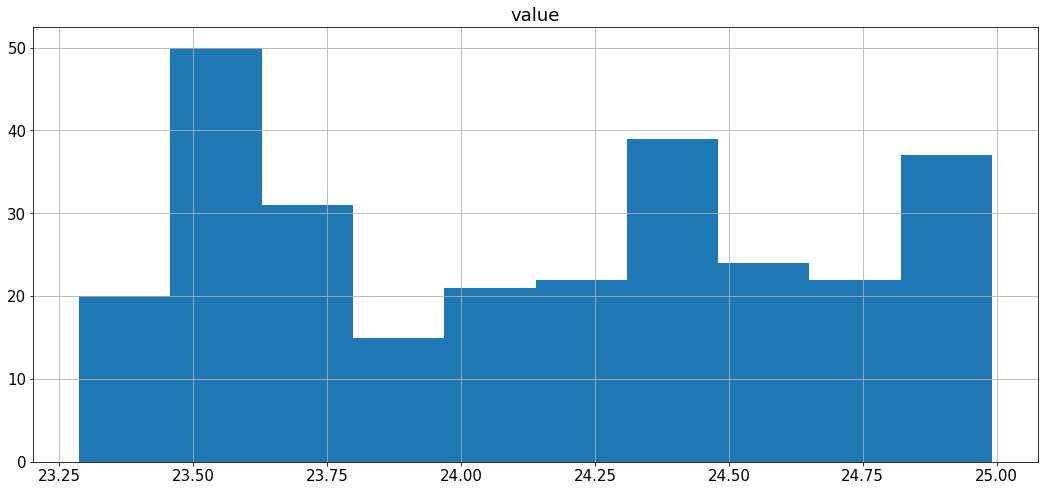

In [18]:
dataset1_log = np.log(dataset1)
dataset1_log.hist()

Прологарифмировав величину и построив гистограмму, получилось бимодальное распределение.

Заметим не однородный график. Посчитаем коэффициент вариации.

In [19]:
row = [u'JB', u'p-value', u'skew', u'kurtosis']
jb_test = sm.stats.stattools.jarque_bera(dataset1)
a = np.vstack([jb_test])
itog = SimpleTable(a, row)
print(itog)


          JB          
----------------------
      25.0274068221479
3.6759336208502727e-06
    0.5342200338817328
     2.001998028798908
----------------------


In [20]:
test = sm.tsa.adfuller(dataset1)

print(f'adf: {test[0]}') # может стоит использовать f-strings - форматирование строк
print('p-value: ', test[1])
print('Critical values: ', test[4])

if test[0] > test[4]['5%']: 
    print ('есть единичные корни, ряд нестационарен')
else:
    print ('единичных корней нет, ряд стационарен')

adf: 1.3051214782223368
p-value:  0.9966374580440959
Critical values:  {'1%': -3.455365238788105, '5%': -2.8725510317187024, '10%': -2.5726375763314966}
есть единичные корни, ряд нестационарен


In [21]:
otgdiff = dataset1.diff(periods=1).dropna()

In [22]:
test = sm.tsa.adfuller(otgdiff)
print('adf:', test[0])
print('p-value:', test[1])
print('Critical values:', test[4])

if test[0] > test[4]['5%']:
    print('Есть единичные корни, ряд не стационарен')
else: 
    print('единичных корней нет,ряд стационарный')
    

adf: -5.907469759813915
p-value: 2.6873990235724697e-07
Critical values: {'1%': -3.455365238788105, '5%': -2.8725510317187024, '10%': -2.5726375763314966}
единичных корней нет,ряд стационарный


Построим график и посмотрим на тренд для графика. 

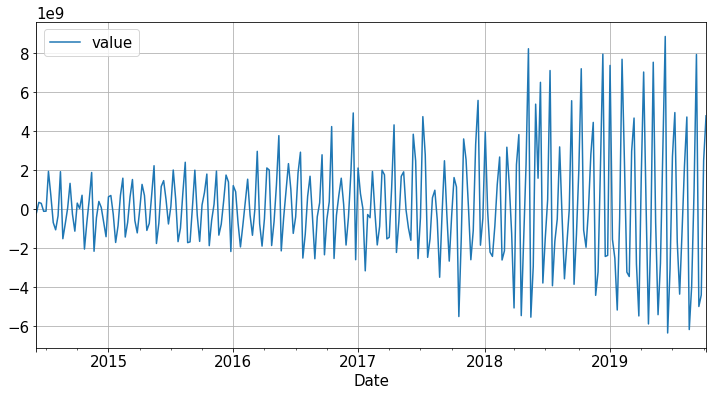

In [23]:
otgdiff.plot(figsize=(12,6))

Видим что тренда нет и таким образом ряд первых разностей является стационарным, а наш исходный ряд — интегрированным рядом первого порядка.

Проведем небольшой анализ (исходного набора) и посмотрим диаграмму рассеяния в зависимости от года, дня, месяца и дня недели.

In [24]:
dtA = dt

In [25]:
dtA.loc[:, 'date'] = dtA.index
dtA.loc[:, 'dayofweek'] = dtA['date'].dt.dayofweek
dtA.loc[:, 'quarter'] = dtA['date'].dt.quarter
dtA.loc[:, 'month'] = dtA['date'].dt.month
dtA.loc[:, 'year'] = dtA['date'].dt.year
dtA.loc[:, 'dayofyear'] = dtA['date'].dt.dayofyear
dtA.loc[:, 'dayofmonth'] = dtA['date'].dt.day
dtA.loc[:, 'weekofyear'] = dtA['date'].dt.isocalendar().week

In [26]:
dtA

,value,date,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
Date,,,,,,,,,
2013-12-30,3457625638,2013-12-30,0,4,12,2013,364,30,1
2013-12-31,3417092149,2013-12-31,1,4,12,2013,365,31,1
2014-01-01,3417092149,2014-01-01,2,1,1,2014,1,1,1
2014-01-02,3417092149,2014-01-02,3,1,1,2014,2,2,1
2014-01-03,3417092149,2014-01-03,4,1,1,2014,3,3,1
...,...,...,...,...,...,...,...,...,...
2019-10-06,64630140507,2019-10-06,6,4,10,2019,279,6,40
2019-10-07,66115288637,2019-10-07,0,4,10,2019,280,7,41
2019-10-08,68424049766,2019-10-08,1,4,10,2019,281,8,41


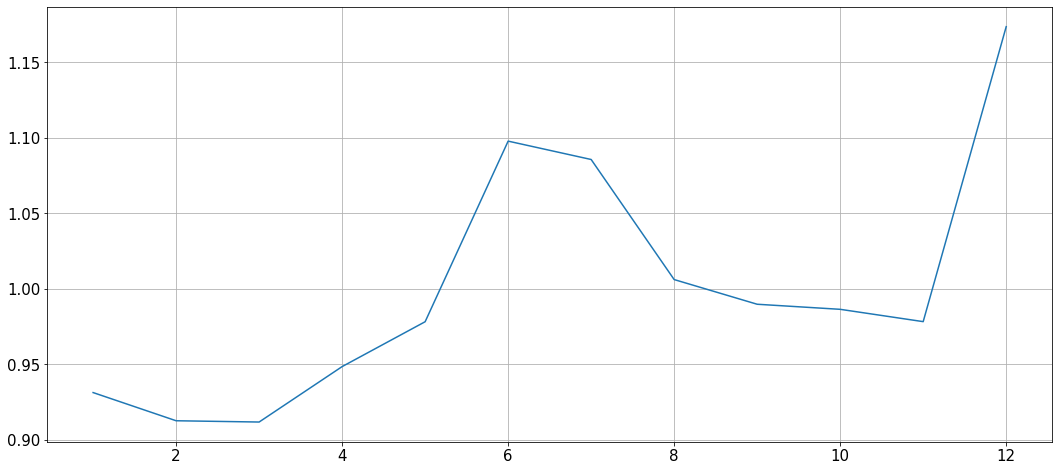

In [27]:
dtA_month = dtA.asfreq(freq='m')
ts_dicomposition = seasonal_decompose(dtA_month['value'], model='multiplicate')
plt.plot(ts_dicomposition.seasonal[1:13].index.month, ts_dicomposition.seasonal[1:13].values)

In [28]:
dtA_by_month = dtA.groupby('month')['value'].median().reset_index()

fig = px.line(dtA_by_month, x='month', y='value')
fig.update_layout(title="Median values by month")
fig.show()

In [29]:
dtA_by_dayofmonth = dtA.groupby('dayofmonth')['value'].median().reset_index()

fig = px.line(dtA_by_dayofmonth, x='dayofmonth', y='value')
fig.update_layout(title="Median values by month")
fig.show()

In [30]:

dtA_by_dayofmonth = dtA.groupby('dayofweek')['value'].median().reset_index()

fig = px.line(dtA_by_dayofmonth, x='dayofweek', y='value')
fig.update_layout(title="Median values by month")
fig.show()

Выводы из проведенного анализа визуализации:

 * значения увеличиваются в 2019 году
 * значения увеличиваются к середине года и падают к концу
 * С 10-го по 15-е число заметно увеличение баланса счета.
 * максимальные значения по выходным и средам.

<a id="section_1"></a>

# Минимум в месяц(baseline) - линейная регрессия


предскажем минимальное значение объема,при подготовке обучающих данных при группировке по месяцу возьмем минимальные значения.

$$ mint \in time(value0..valuet) $$ 











In [166]:
dataset1

,value
Date,
2014-06-01,17206823472
2014-06-08,17032963159
2014-06-15,17389169759
2014-06-22,17695742965
2014-06-29,17593642663
...,...
2019-09-15,68188394412
2019-09-22,63202473102
2019-09-29,58806294388


In [30]:
df_min = dataset1.resample('M').min()

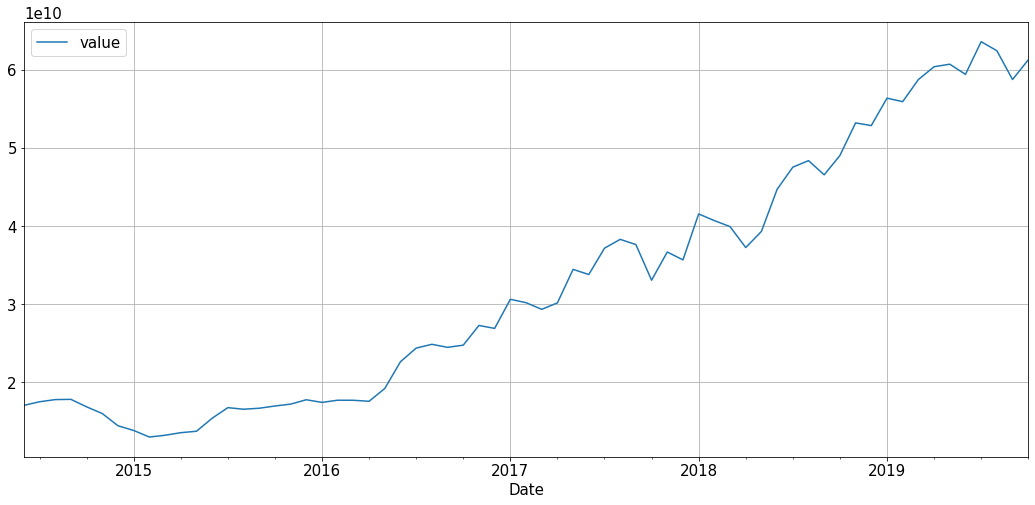

In [31]:
df_min.plot(y='value');

Train dates : 2014-06-30 00:00:00 --- 2019-04-30 00:00:00  (n=59)
Test dates  : 2019-05-31 00:00:00 --- 2019-10-31 00:00:00  (n=6)


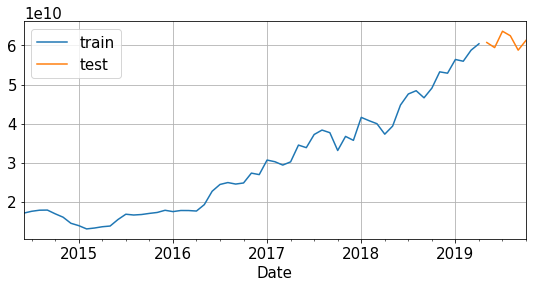

In [32]:
steps = 6
data_train = df_min[:-steps]
data_test  = df_min[-steps:]

print(f"Train dates : {data_train.index.min()} --- {data_train.index.max()}  (n={len(data_train)})")
print(f"Test dates  : {data_test.index.min()} --- {data_test.index.max()}  (n={len(data_test)})")

fig, ax=plt.subplots(figsize=(9, 4))
data_train['value'].plot(ax=ax, label='train')
data_test['value'].plot(ax=ax, label='test')
ax.legend();

In [33]:
def create_features(df, label=None):
    """
    Creates time series features from datetime index
    """
    df_min = df.copy(deep=True)
    df_min['date'] = df_min.index
    df_min['dayofweek'] = df_min['date'].dt.dayofweek
    df_min['quarter'] = df_min['date'].dt.quarter
    df_min['month'] = df_min['date'].dt.month
    df_min['year'] = df_min['date'].dt.year
    df_min['dayofyear'] = df_min['date'].dt.dayofyear
    df_min['dayofmonth'] = df_min['date'].dt.day
    df_min['weekofyear'] = df_min['date'].dt.isocalendar().week
    
    X = df_min[['dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear']]
    if label:
        y = df_min[label]
        return X, y
    return X


X_test, y_test = create_features(data_test, label='value')
X_train, y_train = create_features(data_train, label='value')

Попробуем лин регрессию

In [34]:
feature_name = X_train.columns

scalerX = StandardScaler()
scalerX.fit(X_train) 
X_train = scalerX.transform(X_train)
X_test = scalerX.transform(X_test)

scalerY = StandardScaler()
scalerY.fit(y_train.values.reshape(-1, 1)) 
y_train = scalerY.transform(y_train.values.reshape(-1, 1))
y_test = scalerY.transform(y_test.values.reshape(-1, 1))

In [35]:
model = LinearRegression()
model.fit(X_train, y_train) 
importance = model.coef_

sorted(list(zip(feature_name, importance)), 
       key=lambda x: abs(x[1]))

[('dayofweek', array([  0.0133413 ,   0.14796381,  12.20373205,   0.98123881,
         -12.07925111,   0.02979968,  -0.08537403]))]

In [36]:
pd.DataFrame({
    'variable': feature_name,
    'coef': model.coef_[0] 
}) \
  .round(decimals=2)\
  .sort_values('coef',ascending=False)\
  .style.bar(color=["grey",'lightblue'],align='zero')

,variable,coef
2,month,12.200000
3,year,0.980000
1,quarter,0.150000
5,dayofmonth,0.030000
0,dayofweek,0.010000
6,weekofyear,-0.090000
4,dayofyear,-12.080000


In [37]:
y_predict = model.predict(X_test)
y_predict

array([[1.72685064],
       [1.77387896],
       [1.86479178],
       [1.84052732],
       [1.83526559],
       [1.97846846]])

In [38]:
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_predict))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_predict)))
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_predict)) 
print('R2', r2_score(y_test, y_predict))

Mean Squared Error: 0.21227374534545898
Root Mean Squared Error: 0.46073174987779925
Mean Absolute Error: 0.4445966285511638
R2 -13.630846140491442


In [39]:
y_predict = scalerY.inverse_transform(y_predict)

In [40]:
for_sub = pd.DataFrame(y_predict, index=data_test.index)
for_sub = for_sub.rename({0:'min_value_pred'}, axis=1)

for_sub.min_value_pred = for_sub.min_value_pred.round().astype('int')

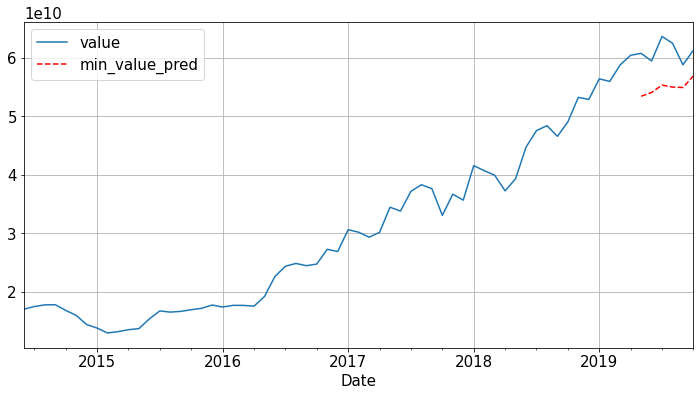

In [41]:
ax = df_min.plot(figsize=(12,6))
for_sub.plot(style='r--', ax=ax);

<a id="section_2"></a>
# Попробуем xgboost

Все модели должны тестироваться на этом промежутке
Train dates : 2014-06-30 00:00:00 --- 2019-05-31 00:00:00  (n=60)
Test dates  : 2019-06-30 00:00:00 --- 2019-10-31 00:00:00  (n=5)

In [42]:
regressor = xgb.XGBRegressor(
    n_estimators=1000,
    reg_lambda=1,
    gamma=0,
    max_depth=5
)

In [43]:
regressor.fit(X_train, y_train)

[13:13:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(max_depth=5, n_estimators=1000)

In [44]:
y_pred = regressor.predict(X_test)

In [45]:
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred)) 
print('R2', r2_score(y_test, y_pred))

Mean Squared Error: 0.04461250312438129
Root Mean Squared Error: 0.2112167207499948
Mean Absolute Error: 0.18590327592899106
R2 -2.0748911886996084


In [46]:
y_predict = scalerY.inverse_transform(y_pred.reshape(-1, 1))

In [47]:
for_sub_xgboost = pd.DataFrame(y_predict, index=data_test.index)
for_sub_xgboost = for_sub_xgboost.rename({0:'min_value_pred'}, axis=1)

for_sub_xgboost.min_value_pred = for_sub_xgboost.min_value_pred.round().astype('int')

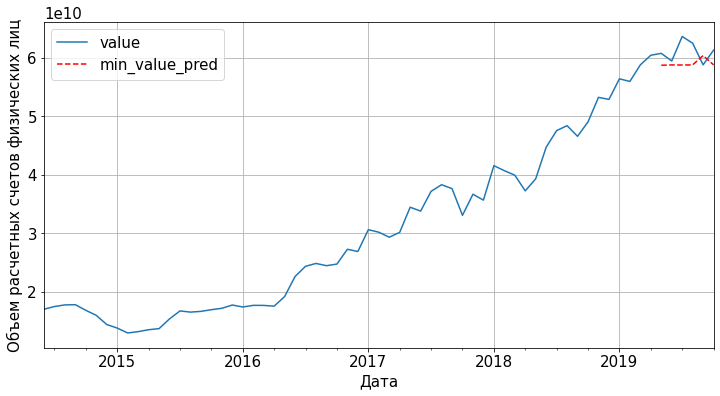

In [48]:
ax = df_min.plot(figsize=(12,6))
for_sub_xgboost.plot(style='r--', ax=ax);
ax.legend()
ax.set_xlabel("Дата")
ax.set_ylabel("Объем расчетных счетов физических лиц");

Сравним Xgboost и линейную регресию 

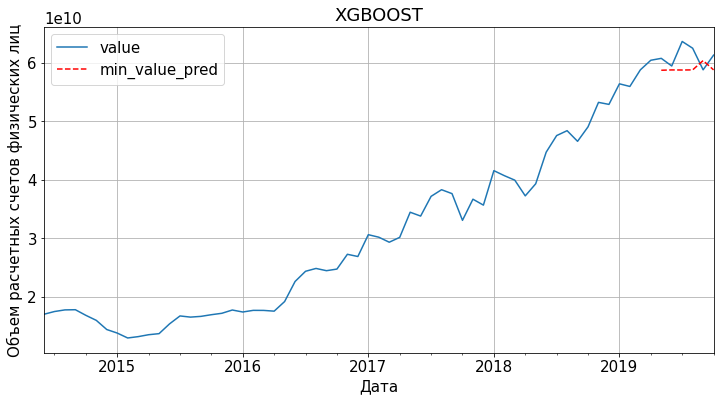

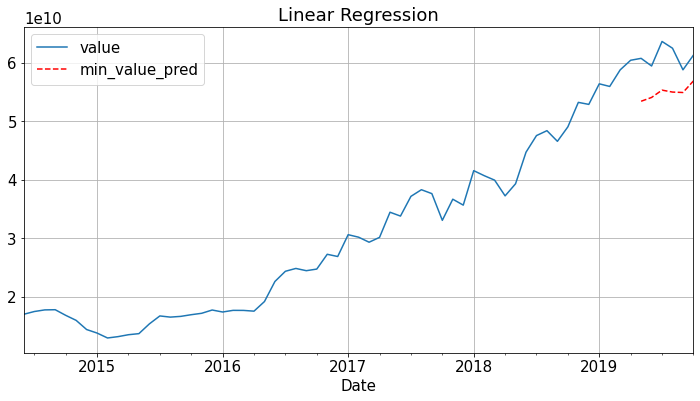

In [49]:
ax = df_min.plot(figsize=(12,6))
for_sub_xgboost.plot(style='r--', ax=ax, title='XGBOOST');
ax.legend()
ax.set_xlabel("Дата")
ax.set_ylabel("Объем расчетных счетов физических лиц");

#--------------------------------------------------------------
ax = df_min.plot(figsize=(12,6))
for_sub.plot(style='r--', ax=ax, title='Linear Regression');


Сравним данные

In [50]:
for_sub = for_sub.rename({'min_value_pred':'Liner_regresion'}, axis=1)
for_sub_xgboost = for_sub_xgboost.rename({'min_value_pred':'XGB'}, axis=1)
LX = pd.concat([for_sub_xgboost, for_sub], axis=1)
data_LX=pd.concat([data_test, LX], axis=1)
data_LX

,value,XGB,Liner_regresion
Date,,,
2019-05-31,60767352266,58733621248,53435363499
2019-06-30,59462446116,58788769792,54084211896
2019-07-31,63652825735,58774278144,55338533397
2019-08-31,62498180060,58794160128,55003757426
2019-09-30,58806294388,60386406400,54931161468
2019-10-31,61317378665,58798055424,56906927324


Видим, что модели не сильно хорошо работают, но XGB работаент чуть лучше.

R2 для моделей отрицательный, поэтому попробуем другие модели и для других шагов

<a id="section_3"></a>
# SARIMA Попробуем рассмотреть сезонность и тренд 


In [51]:
def combine_seasonal_cols(input_df, seasonal_model_results):
    
    input_df['observed'] = seasonal_model_results.observed
    input_df['residual'] = seasonal_model_results.resid
    input_df['seasonal'] = seasonal_model_results.seasonal
    input_df['trend'] = seasonal_model_results.trend

In [52]:
def create_features(df_min, label=None):
    """
    Creates time series features from datetime index
    """
    df_min.loc[:, 'date'] = df_min.index
    df_min.loc[:,'dayofweek'] = df_min['date'].dt.dayofweek
    df_min.loc[:, 'quarter'] = df_min['date'].dt.quarter
    df_min.loc[:, 'month'] = df_min['date'].dt.month
    df_min.loc[:, 'year'] = df_min['date'].dt.year
    df_min.loc[:, 'dayofyear'] = df_min['date'].dt.dayofyear
    df_min.loc[:, 'dayofmonth'] = df_min['date'].dt.day
    df_min.loc[:, 'weekofyear'] = df_min['date'].dt.weekofyear
    
    x = df_min.drop('date', axis=1)
    if label:
        y = df_min[label]
        return x, y
    return x


df_min = create_features(df_min)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: FutureWarning:

Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.



In [53]:
# Re-Run Seasonal Decompose (train data only) 
sd = seasonal_decompose(df_min['value'], model='multiplicate')
combine_seasonal_cols(df_min, sd)

In [54]:
df_min['residual'] = df_min['residual'].fillna(df_min['residual'].mean())
df_min['trend'] = df_min['trend'].interpolate()

In [55]:
df_min['trend'] = df_min['trend'].bfill()

In [56]:
df_min['trend_plus_resid'] = df_min['trend'] * df_min['residual']
df_min = df_min[df_min.trend_plus_resid.notnull()]

In [57]:
df_train = df_min[:'2019-04-30']
df_test = df_min['2019-05-31':]

In [58]:
# Sarimax
sarimax = sm.tsa.statespace.SARIMAX(
    df_train.trend_plus_resid, 
    order=(1, 0, 0) # to be tuned/optimized in a future article
) 
res = sarimax.fit()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.



In [59]:
# Make trend forecast
df_test['trend_prediction'] = res.predict(
    start=np.min(df_test.index), 
    end=np.max(df_test.index)
)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:132: FutureWarning:

The 'freq' argument in Timestamp is deprecated and will be removed in a future version.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [60]:
# Add Seasonal component
seasonal_prediction = df_train[-12:].reset_index()[['month', 'seasonal']]

df_test = df_test.reset_index().merge(
    seasonal_prediction, 
    how='left', 
    left_on='month', 
    right_on='month'
).set_index('Date')

df_test['combined_prediction'] =  df_test['trend_prediction'] * df_test['seasonal_x']

# Add to orignal df for visualization
df_min['prediction'] = df_test['combined_prediction']

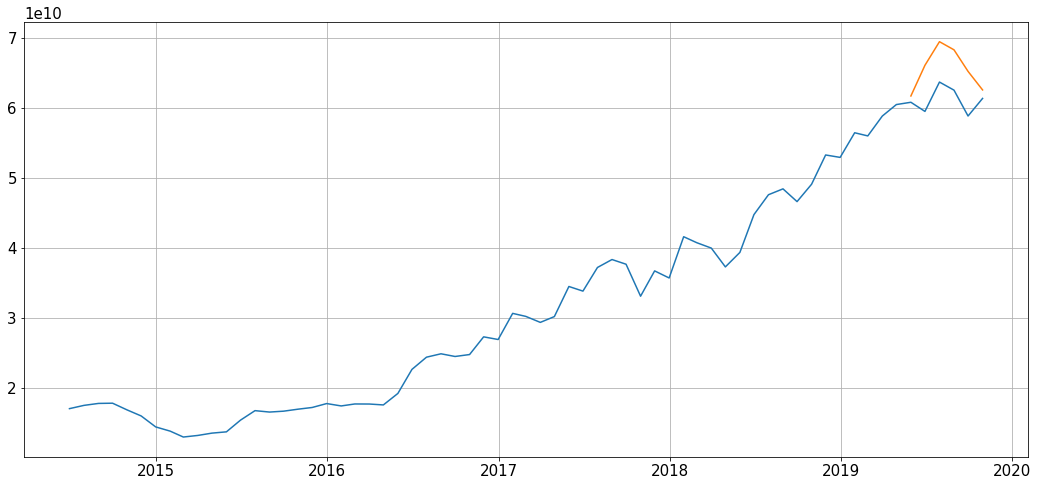

In [61]:
plt.plot(df_min['value'])
plt.plot(df_min['prediction'])

In [62]:
y_predict = df_test['combined_prediction']
y_test = df_test['value']

In [63]:
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_predict))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_predict)))
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_predict)) 
print('R2', r2_score(y_test,y_predict))


Mean Squared Error: 2.5433486895911137e+19
Root Mean Squared Error: 5043162390.396639
Mean Absolute Error: 4431598687.882781
R2 -8.208979970047


<a id='Arima '></a>

# Arima 

**Построение модели** 

Вернемся к первоночальным данным(после обработки) и попробуеим использовать модель ARIMA



Итак, чтобы построить модель нам нужно знать ее порядок, состоящий из 2-х параметров:
p — порядок компоненты AR
d — порядок интегрированного ряда
q — порядок компонетны MA

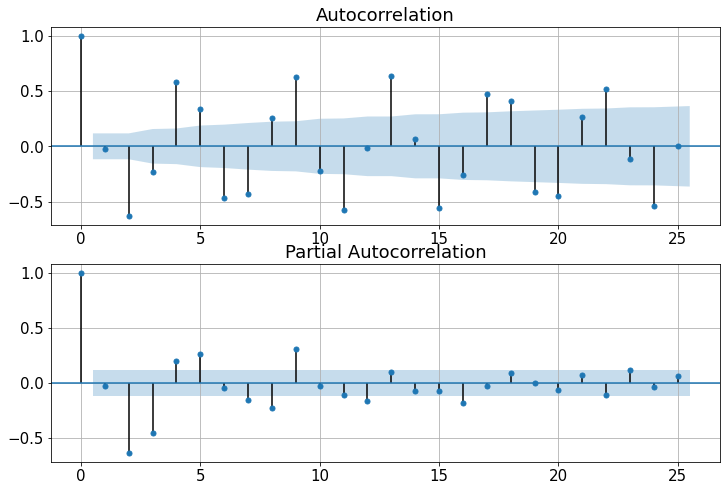

In [35]:
datasetA=dataset1.copy(deep=True)
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(otgdiff.values.squeeze(), lags=25, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(otgdiff, lags=25, ax=ax2)

In [36]:

train, test = datasetA[:'2019-06-10'], datasetA[len(datasetA[:'2019-06-10']):len(datasetA)]
print(len(train), len(test))


263 18


In [37]:
src_data_model = datasetA[:'2019-06-10']
model = sm.tsa.ARIMA(src_data_model, order=(3, 1, 2), freq='W').fit()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/arima_model.py:472: FutureWarning:


statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:548: HessianInversionWarning:

Inverting hessian failed, no bse or cov_params available

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:

In [38]:
print(model.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.value   No. Observations:                  262
Model:                 ARIMA(3, 1, 2)   Log Likelihood               -5928.500
Method:                       css-mle   S.D. of innovations     1548303743.793
Date:                Sat, 29 Oct 2022   AIC                          11871.000
Time:                        14:39:39   BIC                          11895.978
Sample:                    06-08-2014   HQIC                         11881.039
                         - 06-09-2019                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const           1.73e+08        nan        nan        nan         nan         nan
ar.L1.D.value     0.0181        nan        nan        nan         nan         nan
ar.L2.D.value    -0.9409   4.18e-06  -2.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/arima_model.py:1521: RuntimeWarning:

invalid value encountered in sqrt



In [39]:
q_test = sm.tsa.stattools.acf(model.resid, qstat=True) #свойство resid, хранит остатки модели, qstat=True, означает что применяем указынный тест к коэф-ам

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:662: FutureWarning:

The default number of lags is changing from 40 tomin(int(10 * np.log10(nobs)), nobs - 1) after 0.12is released. Set the number of lags to an integer to  silence this warning.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:671: FutureWarning:

fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.



In [40]:
pred = model.predict('2019-05-26','2020-01-31', typ='levels')
trn = datasetA['2019-05-26':]
r2 = r2_score(trn, pred[0:len(trn)])

print ('R^2: %1.2f' % r2)
print('Mean Squared Error:', metrics.mean_squared_error(trn, pred[0:len(trn)]))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(trn, pred[0:len(trn)])))
print('Mean Absolute Error:', metrics.mean_absolute_error(trn, pred[0:len(trn)])) 

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:132: FutureWarning:

The 'freq' argument in Timestamp is deprecated and will be removed in a future version.



R^2: 0.54
Mean Squared Error: 5.717254622939173e+18
Root Mean Squared Error: 2391078129.827458
Mean Absolute Error: 2096415074.0761983


Попробуем предсказать...

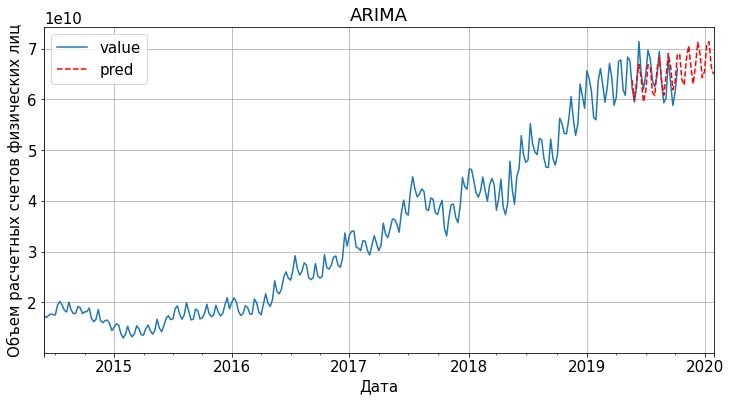

In [41]:
datasetA.plot(figsize=(12,6), title='ARIMA')
ax=pred.plot(style='r--',label='pred')
ax.legend()
ax.set_xlabel("Дата")
ax.set_ylabel("Объем расчетных счетов физических лиц");

In [42]:
dt_pred=datasetA['2019-05-15':]


dt_pred['pred']=pred
dt_pred.head(15)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,value,pred
Date,,
2019-05-19,67637418523,NaN
2019-05-26,62230932665,6.375936e+10
2019-06-02,59462446116,5.978760e+10
2019-06-09,62527939356,6.376018e+10
2019-06-16,71398791210,6.688109e+10
2019-06-23,65053714214,6.399870e+10
2019-06-30,62000221728,5.950589e+10
2019-07-07,64708645517,6.149066e+10
2019-07-14,69674170746,6.680205e+10


<a id="section_5"></a>
# SARIMA

Попробуем  предсказать ряд с помощью SARIMA

В отличии от ARIMA SARIMA позволяет учесть сезонность при построении модели

In [44]:
dataset1

,value
Date,
2014-06-01,17206823472
2014-06-08,17032963159
2014-06-15,17389169759
2014-06-22,17695742965
2014-06-29,17593642663
...,...
2019-09-15,68188394412
2019-09-22,63202473102
2019-09-29,58806294388


In [45]:
df = dataset1.copy(deep=True)

In [46]:
def combine_seasonal_cols(input_df, seasonal_model_results):
    input_df['observed'] = seasonal_model_results.observed
    input_df['residual'] = seasonal_model_results.resid
    input_df['seasonal'] = seasonal_model_results.seasonal
    input_df['trend'] = seasonal_model_results.trend

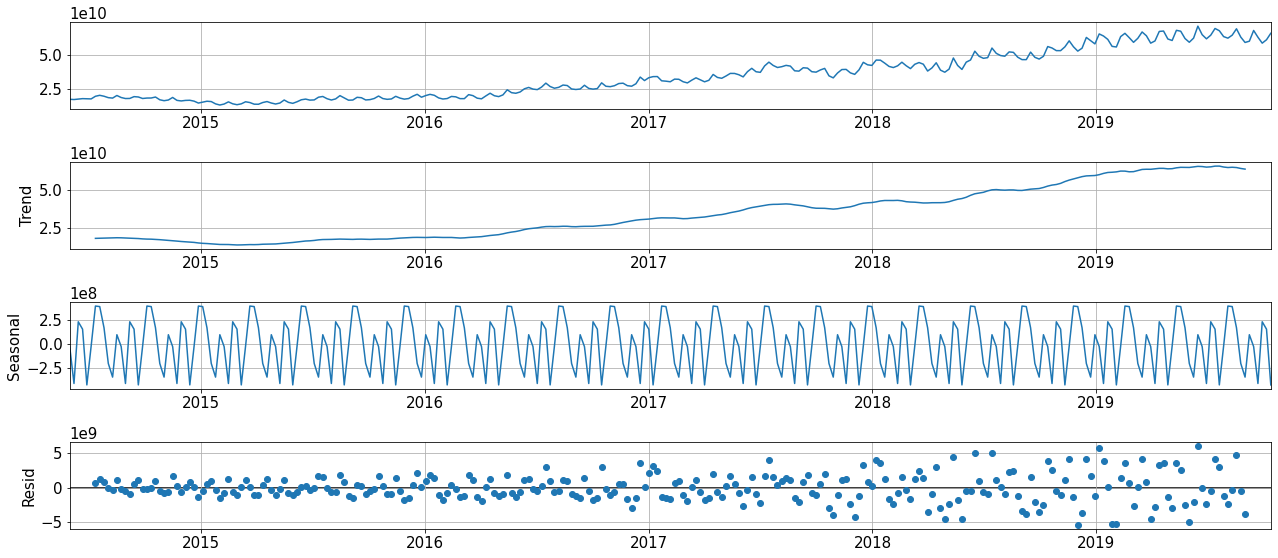

In [47]:
sd = seasonal_decompose(df, period=12)

sd.plot();

In [48]:
combine_seasonal_cols(df, sd) 

In [49]:
df

,value,observed,residual,seasonal,trend
Date,,,,,
2014-06-01,17206823472,1.720682e+10,NaN,-2.726688e+07,NaN
2014-06-08,17032963159,1.703296e+10,NaN,-4.119416e+08,NaN
2014-06-15,17389169759,1.738917e+10,NaN,2.314907e+08,NaN
2014-06-22,17695742965,1.769574e+10,NaN,1.543271e+08,NaN
2014-06-29,17593642663,1.759364e+10,NaN,-4.267248e+08,NaN
...,...,...,...,...,...
2019-09-15,68188394412,6.818839e+10,NaN,-2.726688e+07,NaN
2019-09-22,63202473102,6.320247e+10,NaN,-4.119416e+08,NaN
2019-09-29,58806294388,5.880629e+10,NaN,2.314907e+08,NaN


In [50]:
df_train_S = df[:'2019-05-26']
df_test_S = df['2019-05-26':]

Настройка гиперпараметров SARIMA - сложный процесс

Можно произвести его в автоматическом режиме, например, с помощью `auto_arima` из `pmdarima`

так как прогноз строим по неделям - приймем цикл сезонности = 53 - приблизительно столько недель в году

In [51]:
model = sm.tsa.statespace.SARIMAX(df_train_S['value'],
                                order=(2, 1, 1),
                                seasonal_order=(1, 1, 0, 53))
results = model.fit()

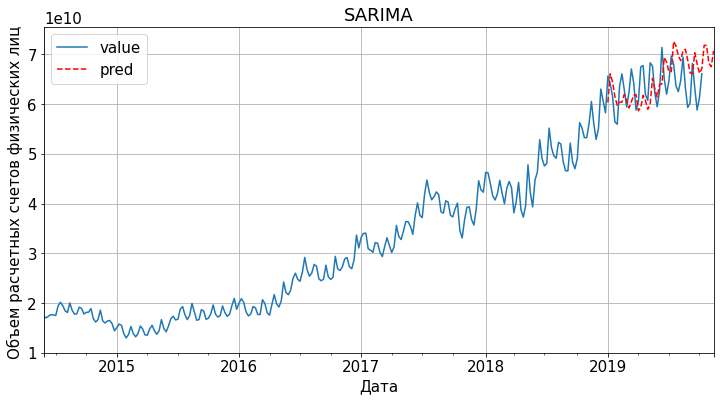

In [52]:
df['value'].plot(figsize=(12,6))
ax=results.predict(start=240,end=285,dynamic=True).plot(style='r--',label='pred',title='SARIMA')
ax.legend()
ax.set_xlabel("Дата")
ax.set_ylabel("Объем расчетных счетов физических лиц ");

In [53]:
df_test_S['pred']=results.predict(start=240,end=285,dynamic=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [54]:
df_test_S=df_test_S['2019-05-26':]

In [55]:
r2 = r2_score(df_test_S['value'], df_test_S['pred'])

print ('R^2: %1.2f' % r2)
print('Mean Squared Error:', metrics.mean_squared_error(df_test_S['value'], df_test_S['pred']))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(df_test_S['value'], df_test_S['pred'])))
print('Mean Absolute Error:', metrics.mean_absolute_error(df_test_S['value'], df_test_S['pred'])) 

R^2: -1.47
Mean Squared Error: 3.0592518576315015e+19
Root Mean Squared Error: 5531050404.427265
Mean Absolute Error: 4762283820.125111


Сравним графики моделей ARIMA И SARIMA 

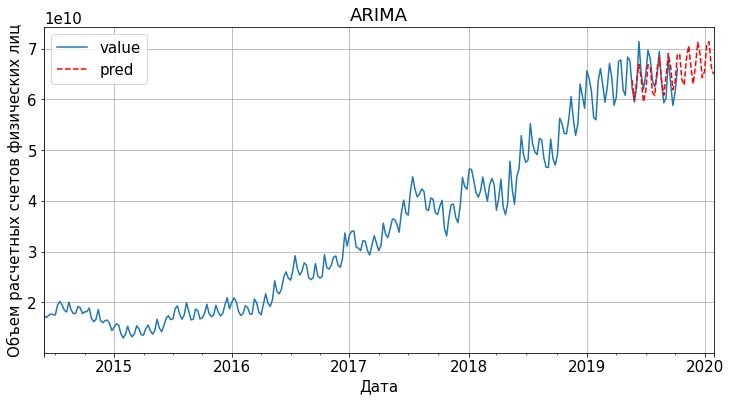

In [56]:
ax =datasetA.plot(figsize=(12,6), title='ARIMA')
ax=pred.plot(style='r--',label='pred')
ax.legend()
ax.set_xlabel("Дата")
ax.set_ylabel("Объем расчетных счетов физических лиц");

#----------------------------------------------------------------


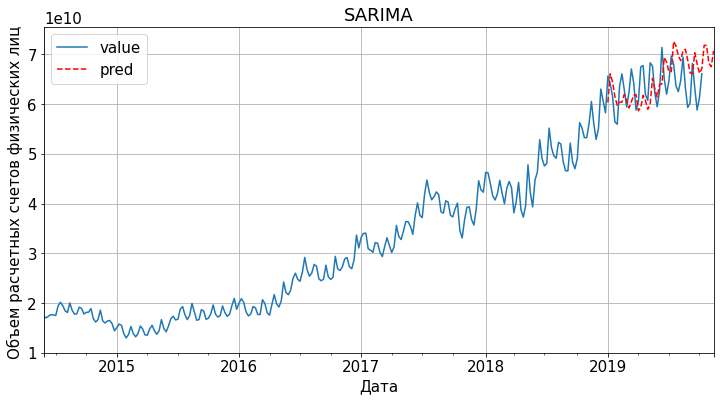

In [57]:
ax=df['value'].plot(figsize=(12,6))
ax=results.predict(start=240,end=285,dynamic=True).plot(style='r--',label='pred',title='SARIMA')
ax.legend()
ax.set_xlabel("Дата")
ax.set_ylabel("Объем расчетных счетов физических лиц ");

Заметим, хоть обе модели работают уже лучше они далеки от идеала. ARIMA работает чуть лучше 

<a id="section_6"></a>
# LSTM

Попробуем предсказать с помощью LSTM

In [58]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [59]:
dataset = dataset1.value.values
dataset = dataset.astype('float32')

In [60]:
dataset = dataset.reshape(-1,1)

Правильнее нормализовать данные после раздение на тестовую и обучающую выборки. В случае, если нормализацию производить до разделения, то информация из тестовой выборки "попадает" в обучающую. Потому что мы вычисляем максимум и минимум по выборке из теста и из трейна.

MinMaxScaler очень чувствителен к выбросам, можно посмотреть другие функции для нормализации данных.

In [61]:
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

In [62]:
len(dataset)


281

In [63]:
# split into train and test sets
train_size = int(len(dataset) * 0.93)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))

261 20


In [64]:
def create_dataset(dataset, look_back=1):
    """
    Эта функция "вытягивает" датасет. 
    
    """
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

In [65]:
# reshape into X=t and Y=t+1
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [66]:
# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [67]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=250, batch_size=5, verbose=2)

Epoch 1/250
52/52 - 2s - loss: 0.1371 - 2s/epoch - 46ms/step
Epoch 2/250
52/52 - 0s - loss: 0.0899 - 98ms/epoch - 2ms/step
Epoch 3/250
52/52 - 0s - loss: 0.0611 - 106ms/epoch - 2ms/step
Epoch 4/250
52/52 - 0s - loss: 0.0465 - 104ms/epoch - 2ms/step
Epoch 5/250
52/52 - 0s - loss: 0.0390 - 102ms/epoch - 2ms/step
Epoch 6/250
52/52 - 0s - loss: 0.0344 - 100ms/epoch - 2ms/step
Epoch 7/250
52/52 - 0s - loss: 0.0306 - 105ms/epoch - 2ms/step
Epoch 8/250
52/52 - 0s - loss: 0.0266 - 100ms/epoch - 2ms/step
Epoch 9/250
52/52 - 0s - loss: 0.0228 - 97ms/epoch - 2ms/step
Epoch 10/250
52/52 - 0s - loss: 0.0192 - 98ms/epoch - 2ms/step
Epoch 11/250
52/52 - 0s - loss: 0.0159 - 97ms/epoch - 2ms/step
Epoch 12/250
52/52 - 0s - loss: 0.0128 - 97ms/epoch - 2ms/step
Epoch 13/250
52/52 - 0s - loss: 0.0102 - 118ms/epoch - 2ms/step
Epoch 14/250
52/52 - 0s - loss: 0.0079 - 101ms/epoch - 2ms/step
Epoch 15/250
52/52 - 0s - loss: 0.0061 - 101ms/epoch - 2ms/step
Epoch 16/250
52/52 - 0s - loss: 0.0047 - 96ms/epoch - 2m

In [68]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

1/1 [==============================] - 0s 18ms/step


Далее необходимо примень обратное преобразование по MinMaxScaler, чтобы вернуться к исходным величинам

In [69]:
pred = scaler.inverse_transform(testPredict)[:, 0]

Но для оценки предсказания, главное посчитать метрики (для этого не обязательно переходить к исходных величинам)

In [70]:
testPredict = testPredict.reshape(1, -1)[0]

In [71]:
r2 = r2_score(testY, testPredict)

print ('R^2: %1.2f' % r2)
print('Mean Squared Error:', metrics.mean_squared_error(testY, testPredict))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(testY, testPredict)))
print('Mean Absolute Error:', metrics.mean_absolute_error(testY, testPredict)) 

R^2: -0.56
Mean Squared Error: 0.005836194
Root Mean Squared Error: 0.07639498
Mean Absolute Error: 0.064216815


In [72]:
df_trainY = pd.DataFrame(trainY, index=dataset1.index[0:len(train)-2])
df_testY = pd.DataFrame(testY, index=dataset1.index[len(train):len(dataset)-2])

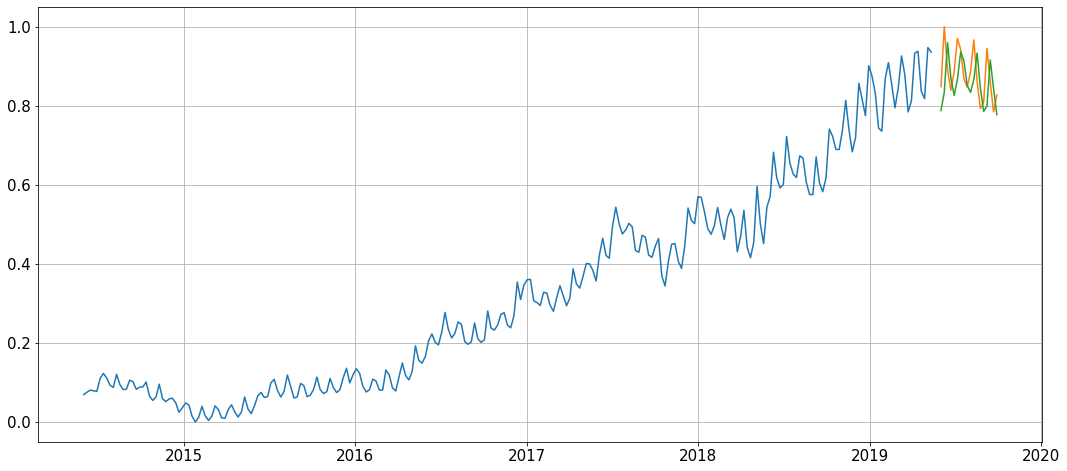

In [73]:
plt.plot(df_trainY.index, df_trainY.values)
plt.plot(df_testY.index, df_testY.values)
plt.plot(df_testY.index, testPredict,label='pred' )
ax.legend()
ax.set_xlabel("Дата")
ax.set_ylabel("Объем расчетных счетов физических лиц");

Заметим,что рекуррентная нейронная сеть с долгой кратковременной памятью сработала куда лучше остальных моделей.

<a id="section_7"></a>
# Skforecast

In [76]:
!pip install skforecast

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 169 kB 4.3 MB/s 
     |████████████████████████████████| 11.2 MB 21.2 MB/s 
     |████████████████████████████████| 283 kB 14.0 MB/s 
     |████████████████████████████████| 100 kB 11.2 MB/s 
     |████████████████████████████████| 308 kB 65.2 MB/s 
     |████████████████████████████████| 78 kB 7.7 MB/s 
     |████████████████████████████████| 81 kB 9.3 MB/s 
     |████████████████████████████████| 209 kB 73.4 MB/s 
     |████████████████████████████████| 42 kB 1.6 MB/s 
     |████████████████████████████████| 965 kB 42.8 MB/s 
     |████████████████████████████████| 78 kB 6.4 MB/s 
     |████████████████████████████████| 112 kB 60.8 MB/s 
     |████████████████████████████████| 50 kB 7.3 MB/s 
     |████████████████████████████████| 147 kB 76.4 MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11137 sha256=6d0c4fe7

In [77]:
# Modeling and Forecasting
# ==============================================================================
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregCustom import ForecasterAutoregCustom
from skforecast.ForecasterAutoregMultiOutput import ForecasterAutoregMultiOutput
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster

from joblib import dump, load

Попробуем библиотеку Skforecast (спойлер предсказания тоже такие себе) 

Train dates : 2014-06-01 00:00:00 --- 2019-05-26 00:00:00  (n=261)
Test dates  : 2019-06-02 00:00:00 --- 2019-10-13 00:00:00  (n=20)


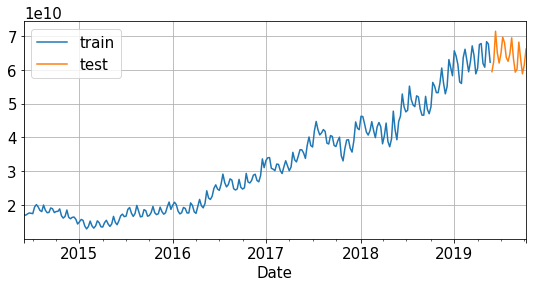

In [78]:
steps = 20
data_train = dataset1[:-steps]
data_test  = dataset1[-steps:]

print(f"Train dates : {data_train.index.min()} --- {data_train.index.max()}  (n={len(data_train)})")
print(f"Test dates  : {data_test.index.min()} --- {data_test.index.max()}  (n={len(data_test)})")

fig, ax=plt.subplots(figsize=(9, 4))
data_train['value'].plot(ax=ax, label='train')
data_test['value'].plot(ax=ax, label='test')
ax.legend();

In [79]:
forecaster = ForecasterAutoreg(
                regressor = RandomForestRegressor(random_state=123),
                lags = 6
                )

forecaster.fit(y=data_train['value'])
forecaster

ForecasterAutoreg 
Regressor: RandomForestRegressor(random_state=123) 
Lags: [1 2 3 4 5 6] 
Transformer for y: None 
Transformer for exog: None 
Window size: 6 
Included exogenous: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [Timestamp('2014-06-01 00:00:00'), Timestamp('2019-05-26 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: W-SUN 
Regressor parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 123, 'verbose': 0, 'warm_start': False} 
Creation date: 2022-10-29 14:47:58 
Last fit date: 2022-10-29 14:47:59 
Skforecast version: 0.5.1 
Python version: 3.7.15 

In [80]:
# Predictions
# ==============================================================================
steps = 20

predictions = forecaster.predict(steps=steps)

data_test.loc[:, 'pred'] = predictions
data_test.head(15)

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,value,pred
Date,,
2019-06-02,59462446116,6.080570e+10
2019-06-09,62527939356,6.625409e+10
2019-06-16,71398791210,6.706159e+10
2019-06-23,65053714214,6.220715e+10
2019-06-30,62000221728,6.062389e+10
2019-07-07,64708645517,6.515501e+10
2019-07-14,69674170746,6.701071e+10
2019-07-21,68004580387,6.227532e+10
2019-07-28,63652825735,6.054366e+10


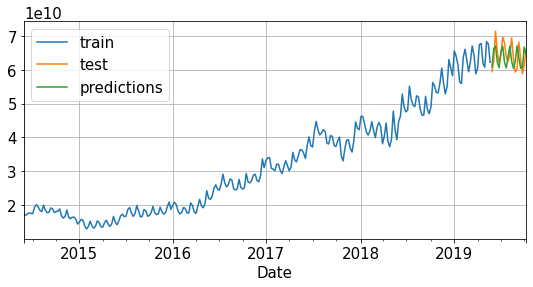

In [81]:
fig, ax = plt.subplots(figsize=(9, 4))
data_train['value'].plot(ax=ax, label='train')
data_test['value'].plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend();

In [82]:
y_true = data_test['value']
y_pred = predictions


print('Mean Squared Error:', metrics.mean_squared_error(y_true, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_true, y_pred)))
print('Mean Absolute Error:', metrics.mean_absolute_error(y_true, y_pred)) 
print('R2', r2_score(y_true, y_pred))

Mean Squared Error: 1.4056702944134425e+19
Root Mean Squared Error: 3749226979.543173
Mean Absolute Error: 3276608254.7594995
R2 -0.09546915198071892


In [83]:
# Create and train forecaster with the best hyperparameters
# ==============================================================================
regressor = RandomForestRegressor(max_depth=15, n_estimators=100, random_state=123)
forecaster = ForecasterAutoreg(
                regressor = regressor,
                lags      = 25
             )

forecaster.fit(y=data_train['value'])

In [84]:
# Predictions
# ==============================================================================
predictions = forecaster.predict(steps=steps)

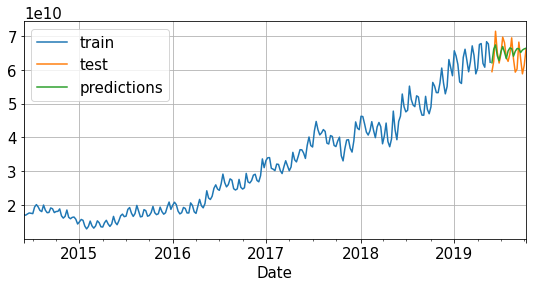

In [85]:
# Plot
# ==============================================================================
fig, ax = plt.subplots(figsize=(9, 4))
data_train['value'].plot(ax=ax, label='train')
data_test['value'].plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend();

In [86]:
y_true = data_test['value']
y_pred = predictions


print('Mean Squared Error:', metrics.mean_squared_error(y_true, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_true, y_pred)))
print('Mean Absolute Error:', metrics.mean_absolute_error(y_true, y_pred)) 
print('R2', r2_score(y_true, y_pred))

Mean Squared Error: 1.1583294095496712e+19
Root Mean Squared Error: 3403423878.3167624
Mean Absolute Error: 2769491618.1409993
R2 0.09728892967522151


Работа модели LSTM неплоха, но далека от идеала.

<a id="section_8"></a>
# Обогатим данные

Можем предположить, что объем счетов физ. лиц зависит от курса $ и €

Попробуем обогатить данные и добавить курс $ и € 




In [89]:
columns=['Date', 'value']


dataset = pd.read_csv('data_1.csv',
                   index_col=['Date'], 
                   parse_dates=['Date'], 
                   dayfirst=True, 
                   header=None, 
                   names=columns, 
                   infer_datetime_format="%d/%m/%y")

dataset = dataset['2016-01-01':]

# dataset.dropna(subset=['value'], how='all')

In [90]:
dt_usd = pd.read_csv('usd.csv',
                   index_col=['Date'], 
                   parse_dates=['Date'],    
                   infer_datetime_format="%d/%m/%y")

In [91]:
dt_eur = pd.read_csv('eur.csv',
                   index_col=['Date'], 
                   parse_dates=['Date'], 
                   infer_datetime_format="%d/%m/%y")

In [92]:
usd_eur = pd.concat([dt_eur, dt_usd['usd']], axis=1)


Text(0.5, 0, 'Дата')

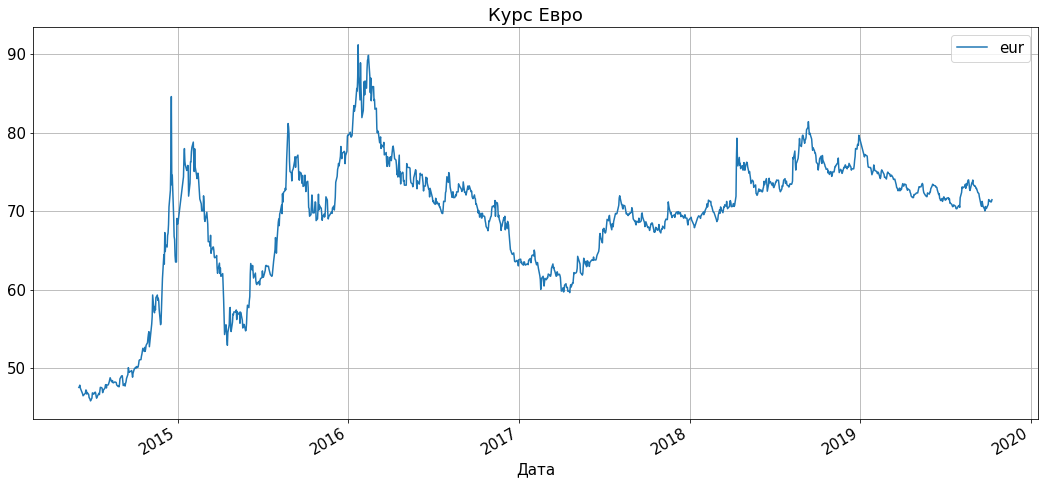

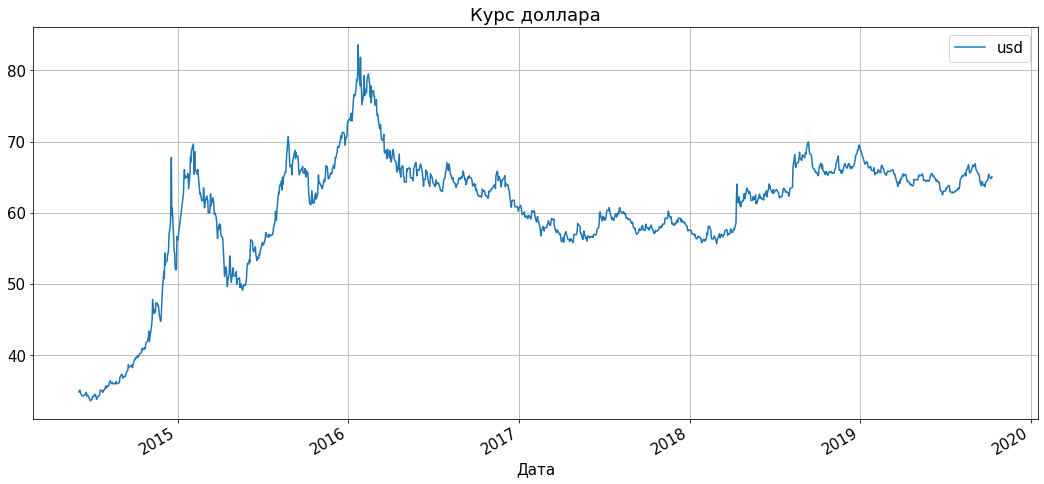

In [93]:
ax = usd_eur.plot(y='eur', title='Курс Евро')
ax.set_xlabel("Дата")
ex = usd_eur.plot(y='usd', title='Курс доллара')
ex.set_xlabel("Дата")



Нет смысла добавлять и доллар и евро - так как они коррелируют (см. графики выше) \
Поэтому оставим только доллар

In [94]:
df_with_currency = pd.concat([dataset,dt_usd], axis=1)


In [95]:
df_with_currency = df_with_currency[~df_with_currency.value.isna()]

In [96]:
df_with_currency = df_with_currency[df_with_currency.index > '2014-06-02']

Заполняем пропуски предыдущими значениями - так как пропущенные значения по валюте - это выходные дни, получается, что в выходные дни у нас стоимость доллара сохраняется с пятницы.

In [97]:
df_with_currency.loc[:, 'usd'] = df_with_currency['usd'].ffill()


Рассмотрим как и раньше с щагом 1Н

In [98]:
df_with_currency

,value,usd
Date,,
2016-01-01,2.269227e+10,72.9299
2016-01-02,2.269227e+10,72.9299
2016-01-03,2.269227e+10,72.9299
2016-01-04,2.269227e+10,72.9299
2016-01-05,2.100330e+10,73.3300
...,...,...
2019-10-06,6.463014e+10,65.0300
2019-10-07,6.611529e+10,65.0300
2019-10-08,6.842405e+10,64.8259


In [99]:
df_with_currency = df_with_currency.resample('W').agg({'value': np.min, 'usd': np.mean})

In [100]:
df_with_currency.loc[:, 'date'] = df_with_currency.index 
df_with_currency.loc[:, 'dayofweek'] = df_with_currency['date'].dt.dayofweek
df_with_currency.loc[:, 'quarter'] = df_with_currency['date'].dt.quarter
df_with_currency.loc[:, 'month'] = df_with_currency['date'].dt.month
df_with_currency.loc[:, 'year'] = df_with_currency['date'].dt.year
df_with_currency.loc[:, 'dayofyear'] = df_with_currency['date'].dt.dayofyear
df_with_currency.loc[:, 'dayofmonth'] = df_with_currency['date'].dt.day
df_with_currency.loc[:, 'weekofyear'] = df_with_currency['date'].dt.isocalendar().week 

df_with_currency = df_with_currency.drop('date', axis=1)

X = df_with_currency[[	'usd','dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear']]

In [101]:
df_with_currency.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 198 entries, 2016-01-03 to 2019-10-13
Freq: W-SUN
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   value       198 non-null    float64
 1   usd         198 non-null    float64
 2   dayofweek   198 non-null    int64  
 3   quarter     198 non-null    int64  
 4   month       198 non-null    int64  
 5   year        198 non-null    int64  
 6   dayofyear   198 non-null    int64  
 7   dayofmonth  198 non-null    int64  
 8   weekofyear  198 non-null    UInt32 
dtypes: UInt32(1), float64(2), int64(6)
memory usage: 14.9 KB


In [102]:
train_size = int(0.93 * len(df_with_currency))
train_size
data_train = df_with_currency[:train_size]
data_test  = df_with_currency[train_size:]

print(f"Train dates : {data_train.index.min()} --- {data_train.index.max()}  (n={len(data_train)})")
print(f"Test dates  : {data_test.index.min()} --- {data_test.index.max()}  (n={len(data_test)})")


Train dates : 2016-01-03 00:00:00 --- 2019-07-07 00:00:00  (n=184)
Test dates  : 2019-07-14 00:00:00 --- 2019-10-13 00:00:00  (n=14)


In [103]:
X_train = data_train.drop('value', axis=1)
y_train = data_train['value']

X_test = data_test.drop('value', axis=1)
y_test = data_test['value']

In [104]:
X['weekofyear'] = X['weekofyear'].astype('int')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [105]:
y_train

Date
2016-01-03    2.269227e+10
2016-01-10    2.087313e+10
2016-01-17    2.016933e+10
2016-01-24    1.823995e+10
2016-01-31    1.741828e+10
                  ...     
2019-06-09    6.252794e+10
2019-06-16    7.139879e+10
2019-06-23    6.505371e+10
2019-06-30    6.200022e+10
2019-07-07    6.470865e+10
Freq: W-SUN, Name: value, Length: 184, dtype: float64

In [106]:
model = LinearRegression()
model.fit(X_train, y_train)

importance = model.coef_

In [107]:
y_predict = model.predict(X_test)

In [108]:
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_predict))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_predict)))
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_predict)) 
print('R2', r2_score(y_test,y_predict))

Mean Squared Error: 1.988545579365194e+19
Root Mean Squared Error: 4459311134.430063
Mean Absolute Error: 3843659442.1648993
R2 -0.6023439204423029


In [109]:
pred_df_with_currency = pd.DataFrame(y_predict, index=data_test.index)
pred_df_with_currency = pred_df_with_currency.rename({0:'min_value_pred'}, axis=1)

pred_df_with_currency.min_value_pred = pred_df_with_currency.min_value_pred.round().astype('int')

(2525.0, 2598.0)

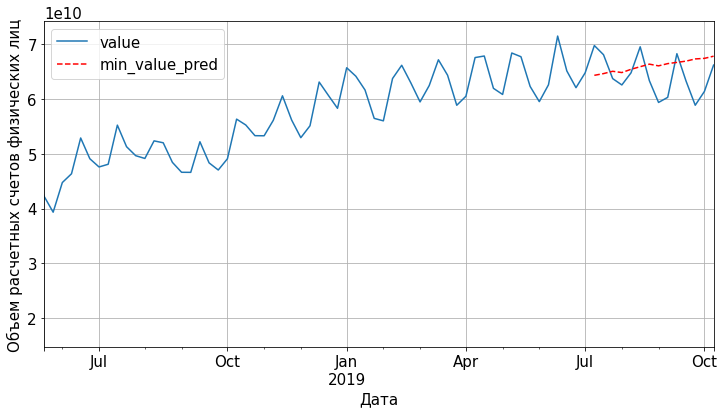

In [110]:
ax = df_with_currency['value'].plot(figsize=(12,6))
pred_df_with_currency.plot(style='r--', ax=ax);
ax.legend()
ax.set_xlabel("Дата")
ax.set_ylabel("Объем расчетных счетов физических лиц");
ax.set_xlim(pd.Timestamp('2018-05-15'), max(df_with_currency.index))

Предсказывает нижние границы - да

<a id="section_9"></a>
# SARIMAX

Попробуем  предсказать ряд с помощью SARIMAX, добавить дополнительную переменную 

SARIMAX в отличии от ARIMA, SARIMA так же при построении и прогнозах может учесть дополнительную переменную, например - это может быть курс доллара.

In [111]:
df = df_with_currency

In [112]:
df_train_S = df[:'2018-11-04']
df_test_S = df['2018-11-04':]

Настройка гиперпараметров SARIMA - сложный процесс

Можно произвести его в автоматическом режиме, например, с помощью `auto_arima` из `pmdarima`

так как прогноз строим по неделям - приймем цикл сезонности = 53 - приблизительно столько недель в году

In [113]:
model = sm.tsa.statespace.SARIMAX(df_train_S['value'],
                                    order=(1, 1, 1),
                                    seasonal_order=(2, 1, 0, 52),
                                     exog=df_train_S['usd'])
results = model.fit()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:868: UserWarning:

Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.



In [114]:
finish = df_test_S.index.max() + pd.Timedelta(weeks=1)

In [115]:
predict = results.predict(df_test_S.index.min(),
                   end=finish,
                   dynamic=True, 
                   exog=df_test_S['usd'])

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:132: FutureWarning:

The 'freq' argument in Timestamp is deprecated and will be removed in a future version.



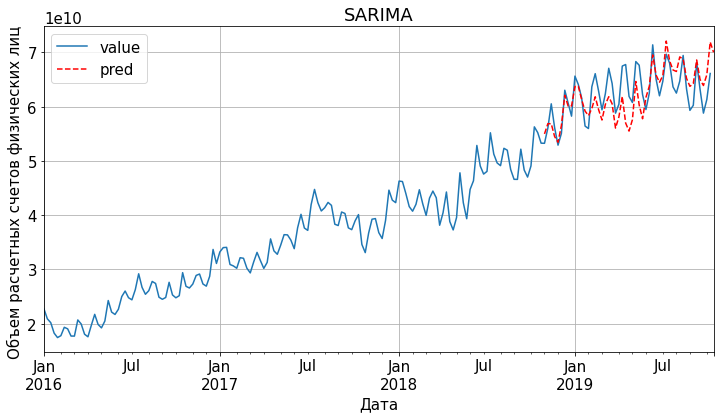

In [116]:
df['value'].plot(figsize=(12,6))
ax=predict.plot(style='r--',label='pred',title='SARIMA')
ax.legend()
ax.set_xlabel("Дата")
ax.set_ylabel("Объем расчетных счетов физических лиц ");

In [117]:
df_test_S.loc[:, 'pred'] = predict

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [118]:
r2 = r2_score(df_test_S['value'], df_test_S['pred'])

print ('R^2: %1.2f' % r2)
print('Mean Squared Error:', metrics.mean_squared_error(df_test_S['value'], df_test_S['pred']))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(df_test_S['value'], df_test_S['pred'])))
print('Mean Absolute Error:', metrics.mean_absolute_error(df_test_S['value'], df_test_S['pred'])) 

R^2: 0.32
Mean Squared Error: 1.2628284867215952e+19
Root Mean Squared Error: 3553629815.72588
Mean Absolute Error: 2895033391.8407063


<a id="section_10"></a>
# Лин регрессия 

Попробуем наконец линейную регрессию и градиентный бустинг

In [119]:
from sklearn import metrics

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from sklearn.linear_model import SGDRegressor
from sklearn.utils import resample
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error,r2_score

Извлечем фичи из дат

In [120]:
train_size = int(0.93 * len(dataset1))
train_size
data_train = dataset1[:train_size]
data_test  = dataset1[train_size:]

print(f"Train dates : {data_train.index.min()} --- {data_train.index.max()}  (n={len(data_train)})")
print(f"Test dates  : {data_test.index.min()} --- {data_test.index.max()}  (n={len(data_test)})")


Train dates : 2014-06-01 00:00:00 --- 2019-05-26 00:00:00  (n=261)
Test dates  : 2019-06-02 00:00:00 --- 2019-10-13 00:00:00  (n=20)


In [121]:
def create_features(dataset1, label=None):
    """
    Creates time series features from datetime index
    """
    dataset1.loc[:, 'date'] = dataset1.index
    dataset1.loc[:, 'dayofweek'] = dataset1['date'].dt.dayofweek
    dataset1.loc[:, 'quarter'] = dataset1['date'].dt.quarter
    dataset1.loc[:, 'month'] = dataset1['date'].dt.month
    dataset1.loc[:, 'year'] = dataset1['date'].dt.year
    dataset1.loc[:, 'dayofyear'] = dataset1['date'].dt.dayofyear
    dataset1.loc[:, 'dayofmonth'] = dataset1['date'].dt.day
    dataset1.loc[:, 'weekofyear'] = dataset1['date'].dt.weekofyear
    
    X = dataset1[['dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear']]
    if label:
        y = dataset1[label]
        return X, y
    return X

X_train, y_train = create_features(data_train, label='value')
X_test, y_test = create_features(data_test, label='value')

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: FutureWarning:

Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.



In [122]:
X_test

,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
Date,,,,,,,
2019-06-02,6,2,6,2019,153,2,22
2019-06-09,6,2,6,2019,160,9,23
2019-06-16,6,2,6,2019,167,16,24
2019-06-23,6,2,6,2019,174,23,25
2019-06-30,6,2,6,2019,181,30,26
2019-07-07,6,3,7,2019,188,7,27
2019-07-14,6,3,7,2019,195,14,28
2019-07-21,6,3,7,2019,202,21,29
2019-07-28,6,3,7,2019,209,28,30


In [123]:
model = LinearRegression()
model.fit(X_train, y_train) 
importance = model.coef_
sorted(list(zip(X_train.columns, importance)), 
       key=lambda x: abs(x[1]))

[('dayofweek', 0.0),
 ('weekofyear', 22308600.495213404),
 ('quarter', 303872765.71613777),
 ('dayofyear', -1299341160.426849),
 ('dayofmonth', 1338141151.2712457),
 ('year', 10040259887.278156),
 ('month', 40249856958.95426)]

In [124]:
pd.DataFrame({
    'variable': X_train.columns,
    'coef': model.coef_ 
}) \
  .round(decimals=2)\
  .sort_values('coef',ascending=False)\
  .style.bar(color=["grey",'lightblue'],align='zero')

,variable,coef
2,month,40249856958.949997
3,year,10040259887.280001
5,dayofmonth,1338141151.270000
1,quarter,303872765.720000
6,weekofyear,22308600.500000
0,dayofweek,0.000000
4,dayofyear,-1299341160.430000


In [125]:
y_predict = model.predict(X_test)

In [126]:
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_predict))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_predict)))
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_predict)) 
print('R2', r2_score(y_test,y_predict))

Mean Squared Error: 3.3841510269222453e+19
Root Mean Squared Error: 5817345637.764913
Mean Absolute Error: 4689644365.295898
R2 -1.637341822169006


In [127]:
for_sub = pd.DataFrame(model.predict(X_test), index=X_test.index)
for_sub = for_sub.rename({0:'value_pred'}, axis=1)

for_sub.value_pred = for_sub.value_pred.round().astype('int')

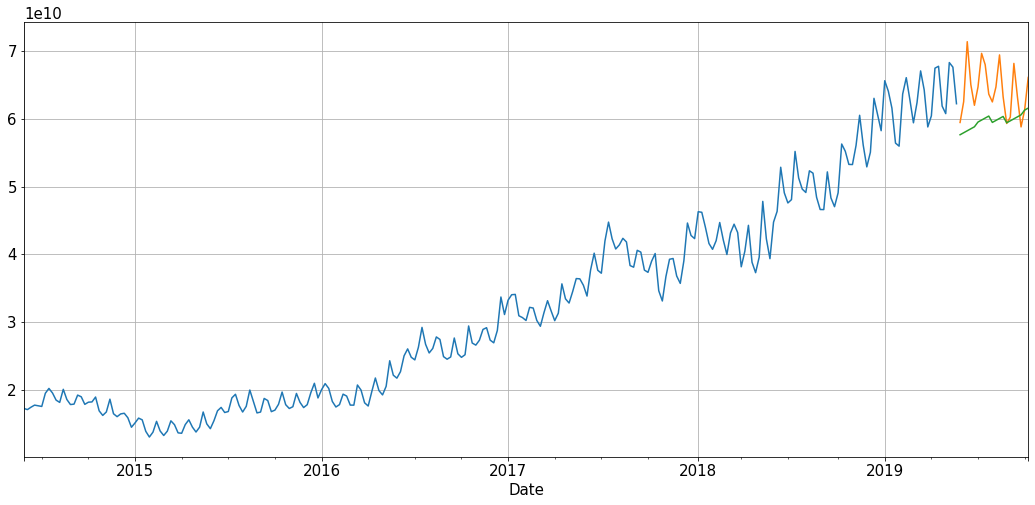

In [128]:
data_train['value'].plot()
data_test['value'].plot()
for_sub['value_pred'].plot()

<a id="section_11"></a>
# Сезонность, тренд и  остатки

Попробуем отделно рассмотреть тренд и остатки и предсказть их c помощью рекурентной нейронной сети

Так же выделим сезонность по неделям - то есть 53 недели в год, каждой недели будет соответствовать свой коэффициент сезонности

In [129]:
columns=['Date', 'value']

dataset = pd.read_csv('data_1.csv',
                   index_col=['Date'], 
                   parse_dates=['Date'], 
                   dayfirst=True, 
                   header=None, 
                   names=columns, 
                   infer_datetime_format="%d/%m/%y")

data_sber = dataset.resample('W').min()

data_sber.head()

,value
Date,
2014-01-05,3417092149
2014-01-12,3320846785
2014-01-19,3300717238
2014-01-26,3330499862
2014-02-02,3282809762


In [130]:
data_sber = data_sber.loc['2015-01-01':]

In [131]:
def combine_seasonal_cols(input_df, seasonal_model_results):
    """
    функция для добавления столбцов к DateFrame
    """

    input_df['observed'] = seasonal_model_results.observed
    input_df['residual'] = seasonal_model_results.resid
    input_df['seasonal'] = seasonal_model_results.seasonal
    input_df['trend'] = seasonal_model_results.trend
    return input_df

Раскладываем сигнал на состовляющую тренда, остатков и сезонности (мультипликативно)

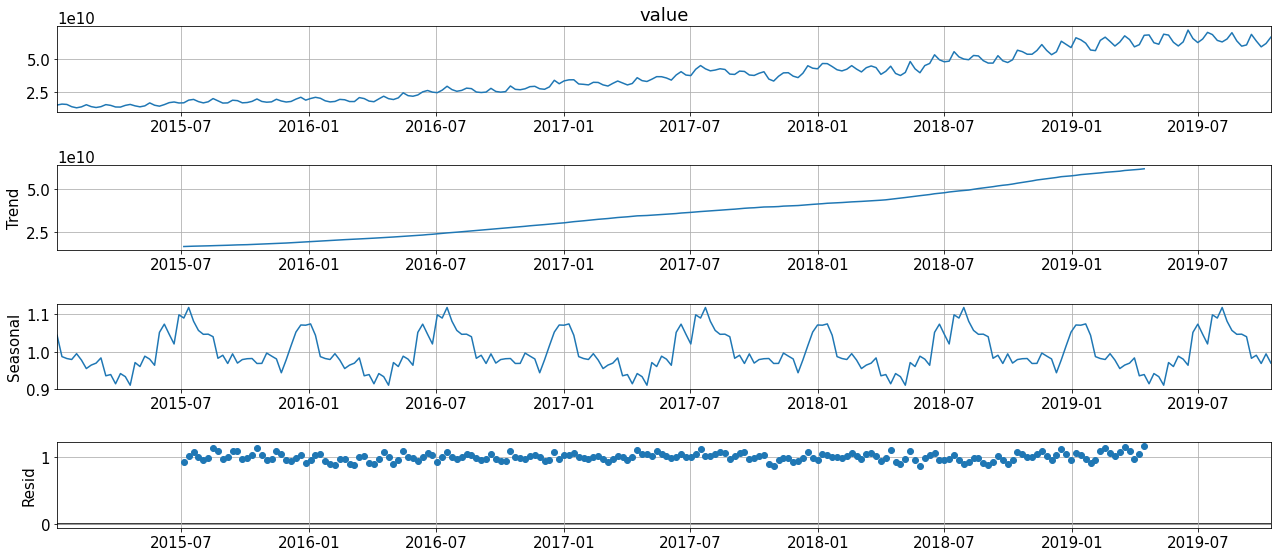

In [132]:
data_sber_sd = seasonal_decompose(data_sber['value'], 'multiplicate', period=53)

data_sber_sd.plot();

In [133]:
data_sber = combine_seasonal_cols(data_sber, data_sber_sd) 

Формирование таблицы сезонности

In [134]:
seasonal = data_sber[['seasonal']]
seasonal['week'] = seasonal.index.isocalendar().week
seasonal = seasonal.groupby(['week']).first()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Рассмотрим тренд и остатки - будем предсказывать их произведение

In [135]:
trend_res = data_sber['trend'] * data_sber['residual'] 
trend_res = trend_res.ffill()
trend_res = trend_res.bfill()

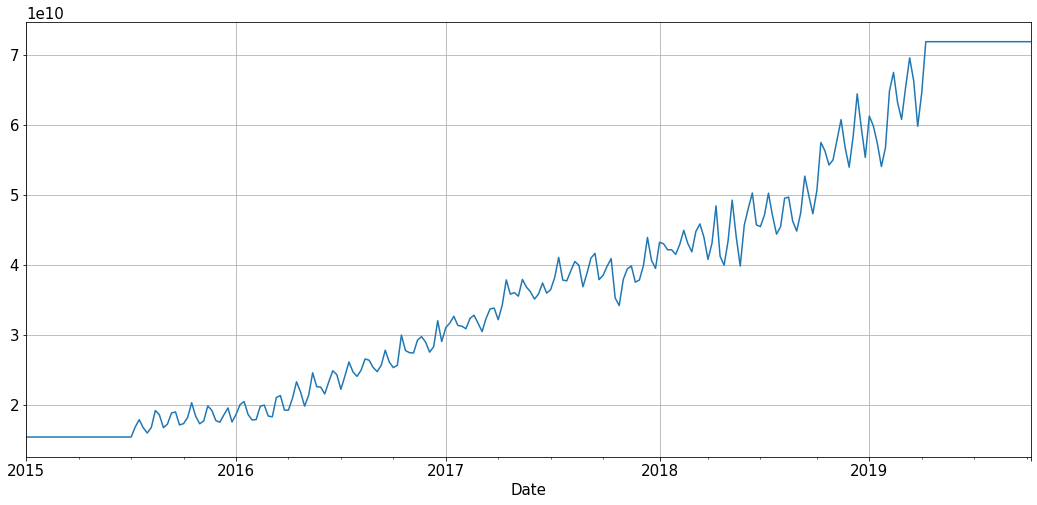

In [136]:
trend_res.plot()

Попробуем предсказать тренд и остатки с помощью LSTM так как показала лучший результат в ходе экспериментов выше

In [137]:
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
trend_res = scaler.fit_transform(trend_res.values.reshape(-1, 1))

In [138]:
# split into train and test sets
train_size = int(len(trend_res) * 0.8)
test_size = len(trend_res) - train_size
train, test = trend_res[0 : train_size, :], trend_res[train_size-6: len(trend_res), :]
print(len(train), len(test))


k = data_sber.reset_index()
data_finish_train = k.loc[train_size]['Date']
data_finish_test = k.loc[len(trend_res)-1]['Date']

print('Дата начала тестового набора:', data_finish_train)

200 56
Дата начала тестового набора: 2018-11-04 00:00:00


In [139]:
def create_dataset(trend1, look_back=1):

    dataX, dataY = [], []
    for i in range(len(trend1)-look_back-1):
        a = trend1[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(trend1[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

In [140]:
look_back = 5
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [141]:
# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [142]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=250, batch_size=5, verbose=2)

Epoch 1/250
39/39 - 2s - loss: 0.1179 - 2s/epoch - 53ms/step
Epoch 2/250
39/39 - 0s - loss: 0.0658 - 73ms/epoch - 2ms/step
Epoch 3/250
39/39 - 0s - loss: 0.0359 - 90ms/epoch - 2ms/step
Epoch 4/250
39/39 - 0s - loss: 0.0208 - 86ms/epoch - 2ms/step
Epoch 5/250
39/39 - 0s - loss: 0.0142 - 80ms/epoch - 2ms/step
Epoch 6/250
39/39 - 0s - loss: 0.0110 - 75ms/epoch - 2ms/step
Epoch 7/250
39/39 - 0s - loss: 0.0088 - 77ms/epoch - 2ms/step
Epoch 8/250
39/39 - 0s - loss: 0.0071 - 83ms/epoch - 2ms/step
Epoch 9/250
39/39 - 0s - loss: 0.0056 - 78ms/epoch - 2ms/step
Epoch 10/250
39/39 - 0s - loss: 0.0044 - 80ms/epoch - 2ms/step
Epoch 11/250
39/39 - 0s - loss: 0.0034 - 84ms/epoch - 2ms/step
Epoch 12/250
39/39 - 0s - loss: 0.0027 - 78ms/epoch - 2ms/step
Epoch 13/250
39/39 - 0s - loss: 0.0022 - 80ms/epoch - 2ms/step
Epoch 14/250
39/39 - 0s - loss: 0.0018 - 78ms/epoch - 2ms/step
Epoch 15/250
39/39 - 0s - loss: 0.0015 - 85ms/epoch - 2ms/step
Epoch 16/250
39/39 - 0s - loss: 0.0013 - 79ms/epoch - 2ms/step
Ep

In [143]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

2/2 [==============================] - 0s 7ms/step


In [144]:
testPredict = testPredict.reshape(1, -1)[0]

In [145]:
r2 = r2_score(testY, testPredict)

print ('R^2: %1.2f' % r2)
print('Mean Squared Error:', metrics.mean_squared_error(testY, testPredict))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(testY, testPredict)))
print('Mean Absolute Error:', metrics.mean_absolute_error(testY, testPredict)) 

R^2: 0.57
Mean Squared Error: 0.005798721664486754
Root Mean Squared Error: 0.07614933791233351
Mean Absolute Error: 0.06790683315913915


In [146]:
pred = scaler.inverse_transform(testPredict.reshape(-1, 1))[:, 0]

Возвращаем сезонность, чтобы построить графики 

In [147]:
df_test = data_sber.loc[data_finish_train:]
df_predict = pd.DataFrame(pred, df_test.index, columns=['trend_resid'])
df_predict['week'] = df_predict.index.isocalendar().week
df_predict = df_predict.reset_index()

In [148]:
df_predict = df_predict.merge(
    seasonal, 
    how='left', 
    left_on='week', 
    right_on='week'
).set_index('Date')

df_predict['value_predict'] = df_predict['trend_resid']*df_predict['seasonal']

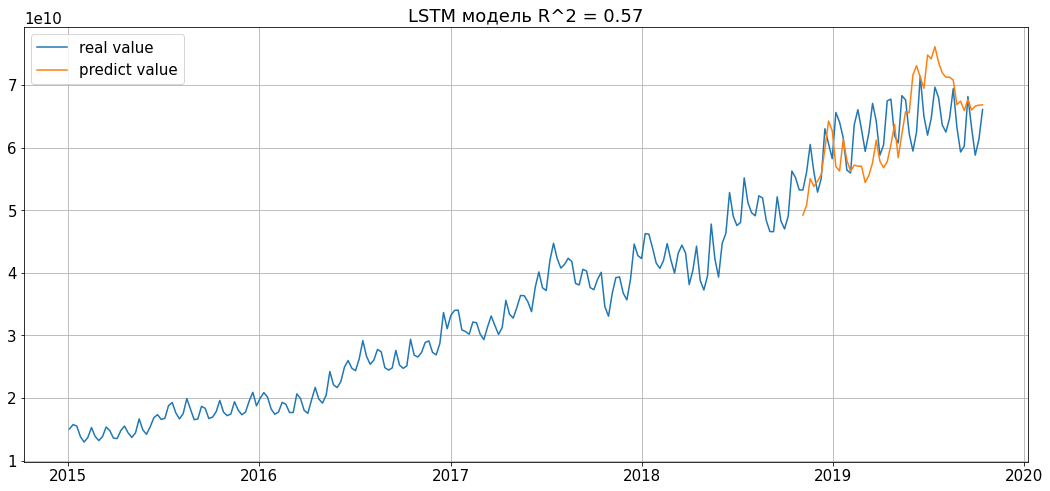

In [149]:
plt.title(f'LSTM модель R^2 = {r2:1.2f}')
plt.plot(data_sber.value, label='real value')
plt.plot(df_predict['value_predict'], label='predict value')
plt.legend()

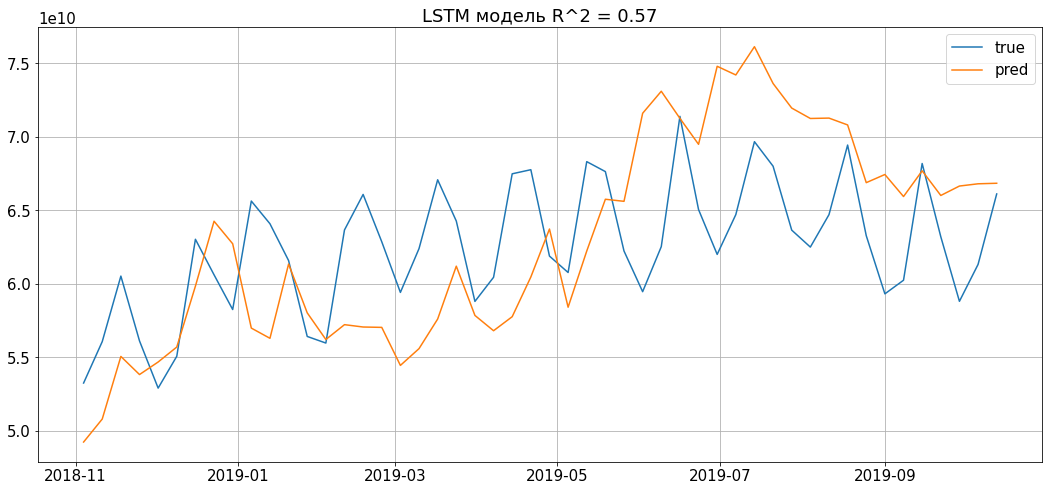

In [150]:
plt.title(f'LSTM модель R^2 = {r2:1.2f}')
plt.plot(data_sber.loc[data_finish_train:, 'value'], label='true')
plt.plot(df_predict['value_predict'], label='pred' )
plt.legend()

Итого: предсказываем произведение тренда на остатки с помощью LSTM и домножаем на коэффициент сезонности по неделям (каждой недели в году соответвует свой коэффициент созенности)

In [151]:
df_for_conclud = data_sber.loc[data_finish_train:, ['value']]
df_for_conclud['value_min_predict'] = df_predict['value_predict']

In [152]:
df_for_conclud = df_for_conclud.rename({'value': 'value_min_real'}, axis = 1)

<a id="section_12"></a>
# Вывод

В ходе проведения анализа вреиенных рядов физ счет, я рассмотрел 9 моделей,конечно они далеки от идеала, в жизни бывают разные случаи. Заметил, что  счет увеличивается к середине месяца, затем падает в течение 10-15 дней и снова начинает расти. В некоторых точках графика наблюдается небольшое проседание ниже уровня предыдущего пика. Общая тенденция направлена на увеличение. Так же из всех модолей лучше всего сработала LSTM. В отличие от других алгоритмов машинного обучения, рекуррентные нейронные сети с долгой кратковременной памятью способны автоматически выявлять признаки из временных последовательностей, обрабатывать многомерные данные, а также выводить последовательности переменной длины, благодаря чему их можно использовать для интервального прогнозирования. А еще одной из причин успеха LSTM по сравнению с SARIMA, что вторую трудно и долго настраивать и подбирать нужные коэффициенты.  

Рассмотрим же минимальные объемы физ счетов, полученные спомощью этой модели..

Расчитаем минимумы за промежуток 1, 2, 3, 6 и 12 месецев

In [153]:
sub = df_for_conclud.head()

In [154]:
dfp_min_m = sub.groupby(pd.Grouper(axis=0, freq='m')).min()
dfp_min_m


,value_min_real,value_min_predict
Date,,
2018-11-30,53243496363,4.922685e+10
2018-12-31,52898432488,5.467459e+10


In [155]:
dfp_min_m.mean()

value_min_real       5.307096e+10
value_min_predict    5.195072e+10
dtype: float64

In [156]:
dfp_min_2m = sub .groupby(pd.Grouper(axis=0, freq='2m')).min()
dfp_min_2m

,value_min_real,value_min_predict
Date,,
2018-11-30,53243496363,4.922685e+10
2019-01-31,52898432488,5.467459e+10


In [157]:
dfp_min_2m.mean()

value_min_real       5.307096e+10
value_min_predict    5.195072e+10
dtype: float64

In [158]:
dfp_min_3m = sub .groupby(pd.Grouper(axis=0, freq='3m')).min()
dfp_min_3m

,value_min_real,value_min_predict
Date,,
2018-11-30,53243496363,4.922685e+10
2019-02-28,52898432488,5.467459e+10


In [159]:
dfp_min_3m.mean()

value_min_real       5.307096e+10
value_min_predict    5.195072e+10
dtype: float64

In [160]:
dfp_min_6m = sub .groupby(pd.Grouper(axis=0, freq='6m')).min()
dfp_min_6m

,value_min_real,value_min_predict
Date,,
2018-11-30,53243496363,4.922685e+10
2019-05-31,52898432488,5.467459e+10


In [161]:
dfp_min_6m.mean()

value_min_real       5.307096e+10
value_min_predict    5.195072e+10
dtype: float64

In [162]:
dfp_min_12m = sub .groupby(pd.Grouper(axis=0, freq='12m')).min()
dfp_min_12m

,value_min_real,value_min_predict
Date,,
2018-11-30,53243496363,4.922685e+10
2019-11-30,52898432488,5.467459e+10


In [163]:
dfp_min_12m.mean()

value_min_real       5.307096e+10
value_min_predict    5.195072e+10
dtype: float64

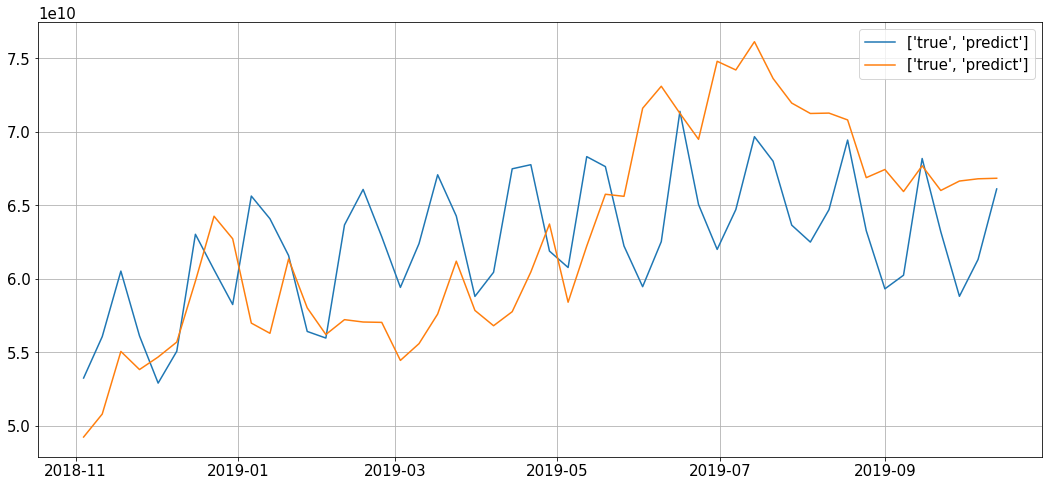

In [164]:
plt.plot(df_for_conclud, label = ['true', 'predict'])
plt.legend()

Так же входе проделанной работы я пробовал использовать библиотеку Фейсбука
[Пророк](https://colab.research.google.com/drive/107bUid_sWutfmur7GelqBCImcTAKOC1j?usp=sharing)

И BL инструмент Power BL 

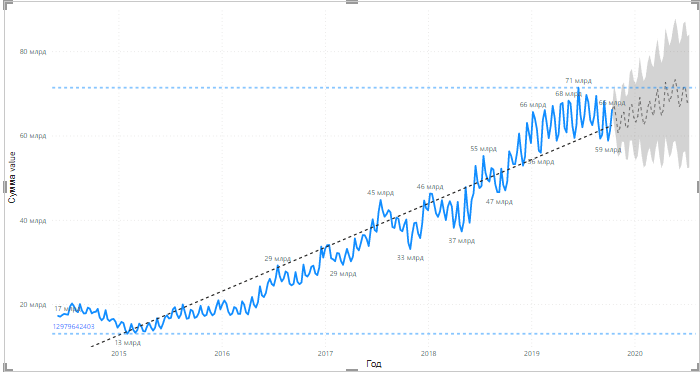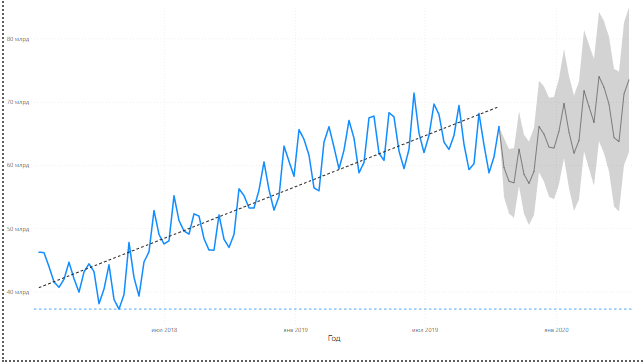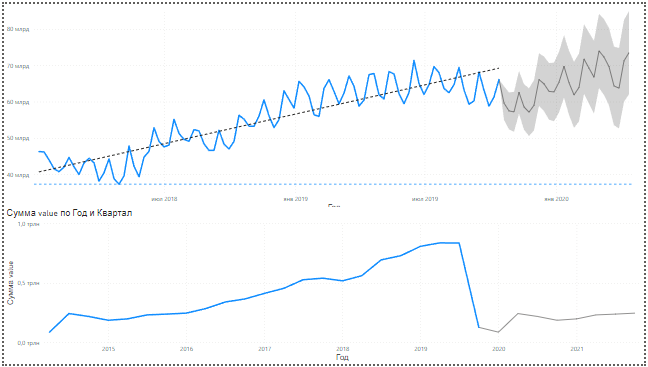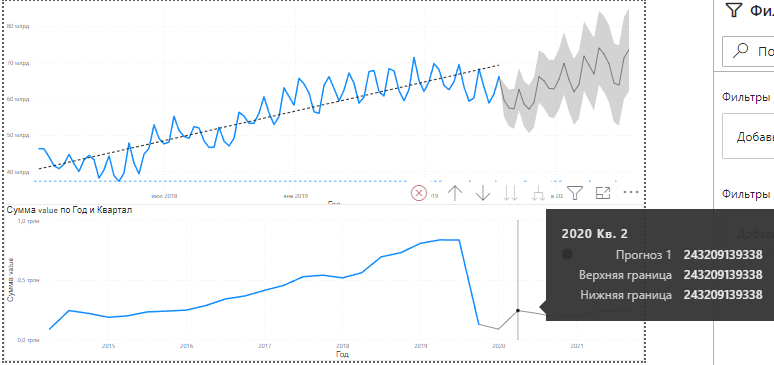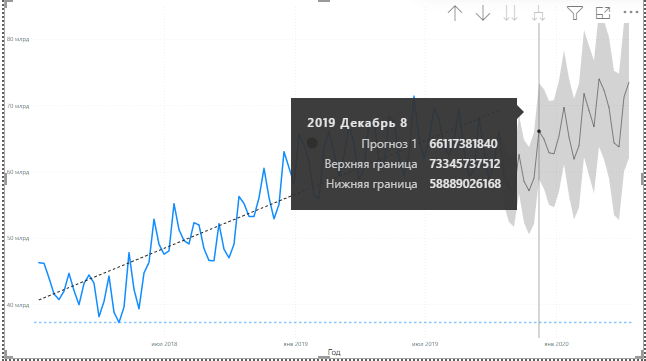

В общем и целом скажу, что мне понравилось работать с временными рядами и при бОльшем количесвтве данных о физ лицах и о происходящей экономической ситуации, а также при бОльшем количестве моих знаний и умений в аналитике данных результат мог получиться гораздо лучше \
Спасибо Сберу за предоставленную возможность!)

